In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
import scipy.stats as stats
import seaborn as sns
import os
from joblib import dump, load

In [2]:
def analyse(fichier, nom_fichier):
    print("="*50)
    print(f'Analyse du fichier {nom_fichier} :')
    print("="*50)
    print(f"Forme du fichier : {fichier.shape}")

    doublons = fichier.duplicated().sum()
    manquant = fichier.isnull().sum()
    pourcentage_manquant = np.round(((manquant / len(fichier)) * 100), 2)

    print('-'*50)
    print(f'Il y a {doublons} doublons')
    print('-'*50)

    print(f'Données manquantes par colonne :')
    if manquant.sum() == 0:
        print("Il n'y a pas de données manquantes")
    else :
        print(manquant)
        print('-'*50)
        print('Pourcentage de données manquantes par colonne :')
        print(pourcentage_manquant)
    print('-'*50)

    print('Informations sur les colonnes :')
    fichier.info()
    print('-'*50)
    fichier.describe()

In [3]:
def tableau_recap(fichiers):
    tableau = []

    for fichier in fichiers:
        df = pd.read_csv(fichier)

    # Nombre de lignes et de colonnes
        lignes, colonnes = df.shape

    # Doublons
        doublons = df.duplicated().sum()

    # Données manquantes
        manquant = df.isnull().sum()
        pourcentage_manquant = np.round(((manquant / len(df)) * 100), 2)

    # Colonnes avec des données manquantes
        colonnes_manquantes = manquant[manquant > 0].count()

    # Pourcentage global données manquantes
        total_données_manquantes = manquant.sum()
        total_pourcentage_manquant = np.round((total_données_manquantes / (len(df) * len(df.columns)) * 100), 2)

    # Ajout des informations au tableau
        tableau.append([fichier, lignes, colonnes, doublons, colonnes_manquantes, np.round(total_pourcentage_manquant,2), manquant[manquant > 0].to_dict()])

    # Création du dataframe récapitulatif
    df_recap = pd.DataFrame(tableau, columns = ["Fichier", "Lignes", "Colonnes", "Doublons", "Colonnes avec données manquantes (N)", "Pourcentage manquant (N)", "Données manquantes par colonne"])

    return df_recap

In [4]:
def afficher_taux_remplissage(df):
    taux_remplissage = df.isna().mean().sort_values() * 100
    taux_remplissage = taux_remplissage[taux_remplissage > 0]  # Ne montrer que les colonnes concernées
    display(taux_remplissage.to_frame("Taux de valeurs manquantes (%)"))
    msno.bar(df)  # Visualisation avec Missingno

In [5]:
def nettoyer_et_selectionner_features(df, target_column='categories'):
    colonnes_utiles = [
        'categories', 'product_name', 'pnns_groups_1', 'pnns_groups_2',
        'nutriscore_grade', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
        'sugars_100g', 'proteins_100g', 'fiber_100g', 'salt_100g', 'ingredients_text'
    ]
    df = df[colonnes_utiles]

    # Supprimer les doublons
    df = df.drop_duplicates()

    return df

In [6]:
def analyse_et_nettoyage_auto(df, target_column='categories'):
    # 1. Filtrage sur la France
    df_france = df[df["countries_tags"].str.contains("france", na=False)]
    print(f"Nombre de produits après filtrage sur la France : {df_france.shape[0]}")

    # 2. Nettoyage et sélection des features
    df_cleaned = nettoyer_et_selectionner_features(df_france, target_column)
    print(f"Taille du dataset après nettoyage : {df_cleaned.shape}")

    # 3. Suppression des lignes sans valeur cible
    df_cleaned = df_cleaned[~df_cleaned[target_column].isnull()].copy()
    print(f"Après suppression des lignes sans '{target_column}': {df_cleaned.shape[0]} lignes")

    # 4. Séparation de la cible et des features
    X = df_cleaned.drop(target_column, axis=1)
    y = df_cleaned[target_column]

    # 5. Suppression des doublons
    print(f"Nombre de doublons avant suppression : {df_cleaned.duplicated(subset=['product_name', 'ingredients_text', 'nutriscore_grade']).sum()}")
    df_cleaned = df_cleaned.drop_duplicates(subset=["product_name", "ingredients_text", "nutriscore_grade"])
    print(f"Nombre de lignes après suppression des doublons : {df_cleaned.shape[0]}")

    # 6. Afficher le taux de remplissage des features
    afficher_taux_remplissage(X)

    return df_cleaned, X, y

# Utilisation de la fonction
# df_cleaned, X, y = analyse_et_nettoyage_auto(dataset)

In [7]:
def outliers_iqr(df, columns):
    outliers_dict = {}

    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        print(f"\n {col} - IQR: {IQR}, Bornes: [{lower_bound}, {upper_bound}]")

        # Stocker les valeurs aberrantes dans un dictionnaire
        outliers_dict[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)][[col, "product_name"]]

    return outliers_dict

In [8]:
def graphiques(df, colonnes, plot_type="boxplot", ncols=2, figsize_base=(6, 4), bins=30, log=False):
    """
    Affiche plusieurs graphiques en grille pour les colonnes spécifiées d'un DataFrame avec un style amélioré.

    Paramètres:
    - df: DataFrame contenant les données.
    - colonnes: Liste des colonnes à visualiser.
    - plot_type: Type de graphique à afficher (par défaut: "boxplot").
    - ncols: Nombre de colonnes dans la grille de graphiques (par défaut: 2).
    - figsize_base: Taille de base de chaque graphique (par défaut: (6, 4)).
    - bins: Nombre de bins pour les histogrammes (par défaut: 30).
    - log: Si True, applique une échelle logarithmique aux axes (par défaut: False).
    """

    df[colonnes] = df[colonnes].apply(pd.to_numeric, errors='coerce')

    nb_colonnes = len(colonnes)
    nrows = (nb_colonnes + ncols - 1) // ncols

    plt.style.use("seaborn-v0_8-darkgrid")

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize_base[0] * ncols, figsize_base[1] * nrows))
    axes = axes.flatten()

    plot_func = getattr(sns, plot_type, None)
    if plot_func is None:
        raise ValueError(f"Type de graphique '{plot_type}' non supporté.")

    for i, col in enumerate(colonnes):
        if plot_type == "histplot":
            plot_func(
                data=df, x=col, ax=axes[i], kde=True, bins=bins,
                color="darkorange", edgecolor="black", linewidth=1.2
            )
        else:
            plot_func(data=df, y=col, ax=axes[i])

        axes[i].set_title(f"{plot_type.capitalize()} de {col}", fontsize=12)
        axes[i].set_xlabel(col, fontsize=10)
        axes[i].set_ylabel("Fréquence", fontsize=10)

        # Appliquer l'échelle logarithmique si log est True
        if log:
            axes[i].set_yscale('log')
            if plot_type == "histplot":
                axes[i].set_xscale('log')

    # Supprime les axes vides s'il y en a
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [9]:
def cercle_correlations(acp, features, axis1=0, axis2=1):
    fig, ax = plt.subplots(figsize=(5, 5))
    for i in range(len(features)):
        ax.arrow(0, 0, acp.components_[axis1, i], acp.components_[axis2, i], head_width=0.05, head_length=0.05, fc='k', ec='k')
        ax.text(acp.components_[axis1, i] * 1.2, acp.components_[axis2, i] * 1.2, features[i], color='k', ha='center', va='center')
    circle = plt.Circle((0, 0), 1, color='blue', fill=False)
    ax.add_artist(circle)
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.xlabel(f'Composante {axis1 + 1}')
    plt.ylabel(f'Composante {axis2 + 1}')
    plt.title(f'Cercle des corrélations (Composantes {axis1 + 1} et {axis2 + 1})', y=1.05)
    plt.grid()
    plt.show()

In [10]:
# Pour faire un échantillon de la base de données

#fichier_base = 'data\en.openfoodfacts.org.products.csv'
#echantillon = 'data\echantillon.csv'
#chunksize = 50000
#sample_fraction = 0.1

#sampled_data = []

#for chunk in pd.read_csv(fichier_base, sep='\t', low_memory=False, on_bad_lines='skip', chunksize=chunksize):
#    sampled_data.append(chunk.sample(frac=sample_fraction, random_state=1))

#df_sample = pd.concat(sampled_data)
#df_sample.to_csv(echantillon, index=False)
#print(f"Échantillon enregistré dans {echantillon} avec {len(df_sample)} lignes.")

LECTURE DES DONNÉES & ANALYSE GLOBALE

In [11]:
fichiers = [
    'data/echantillon.csv'
]

df_recap = tableau_recap(fichiers)
df_recap

C:\Users\Thomas\AppData\Local\Temp\ipykernel_5924\1982511734.py:5: DtypeWarning: Columns (0,11,33,35,53,67,72) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fichier)


Fichier  Lignes  Colonnes  Doublons  \
0  data/echantillon.csv  365015       206         0   

   Colonnes avec données manquantes (N)  Pourcentage manquant (N)  \
0                                   197                     78.04   

                      Données manquantes par colonne  
0  {'creator': 1, 'last_modified_by': 12056, 'las...

In [12]:
dataset = pd.read_csv('data/echantillon.csv')
analyse(dataset, 'Dataset')

C:\Users\Thomas\AppData\Local\Temp\ipykernel_5924\1390803481.py:1: DtypeWarning: Columns (0,11,33,35,53,67,72) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('data/echantillon.csv')


Analyse du fichier Dataset :
Forme du fichier : (365015, 206)
--------------------------------------------------
Il y a 0 doublons
--------------------------------------------------
Données manquantes par colonne :
code                     0
url                      0
creator                  1
created_t                0
created_datetime         0
                     ...  
inositol_100g       365007
carnitine_100g      365009
sulphate_100g       364997
nitrate_100g        364998
acidity_100g        365013
Length: 206, dtype: int64
--------------------------------------------------
Pourcentage de données manquantes par colonne :
code                  0.0
url                   0.0
creator               0.0
created_t             0.0
created_datetime      0.0
                    ...  
inositol_100g       100.0
carnitine_100g      100.0
sulphate_100g       100.0
nitrate_100g        100.0
acidity_100g        100.0
Length: 206, dtype: float64
-------------------------------------------------

# 1 : Nettoyage et filtrage

Nombre de produits après filtrage sur la France : 112237
Taille du dataset après nettoyage : (104014, 13)
Après suppression des lignes sans 'categories': 56271 lignes
Nombre de doublons avant suppression : 3770
Nombre de lignes après suppression des doublons : 52501


Taux de valeurs manquantes (%)
pnns_groups_1                             0.191928
pnns_groups_2                             0.191928
nutriscore_grade                          0.348314
product_name                              1.355938
proteins_100g                            16.974996
fat_100g                                 17.070960
carbohydrates_100g                       17.083400
sugars_100g                              17.122496
saturated-fat_100g                       17.238009
salt_100g                                19.569583
ingredients_text                         47.672869
fiber_100g                               64.676299

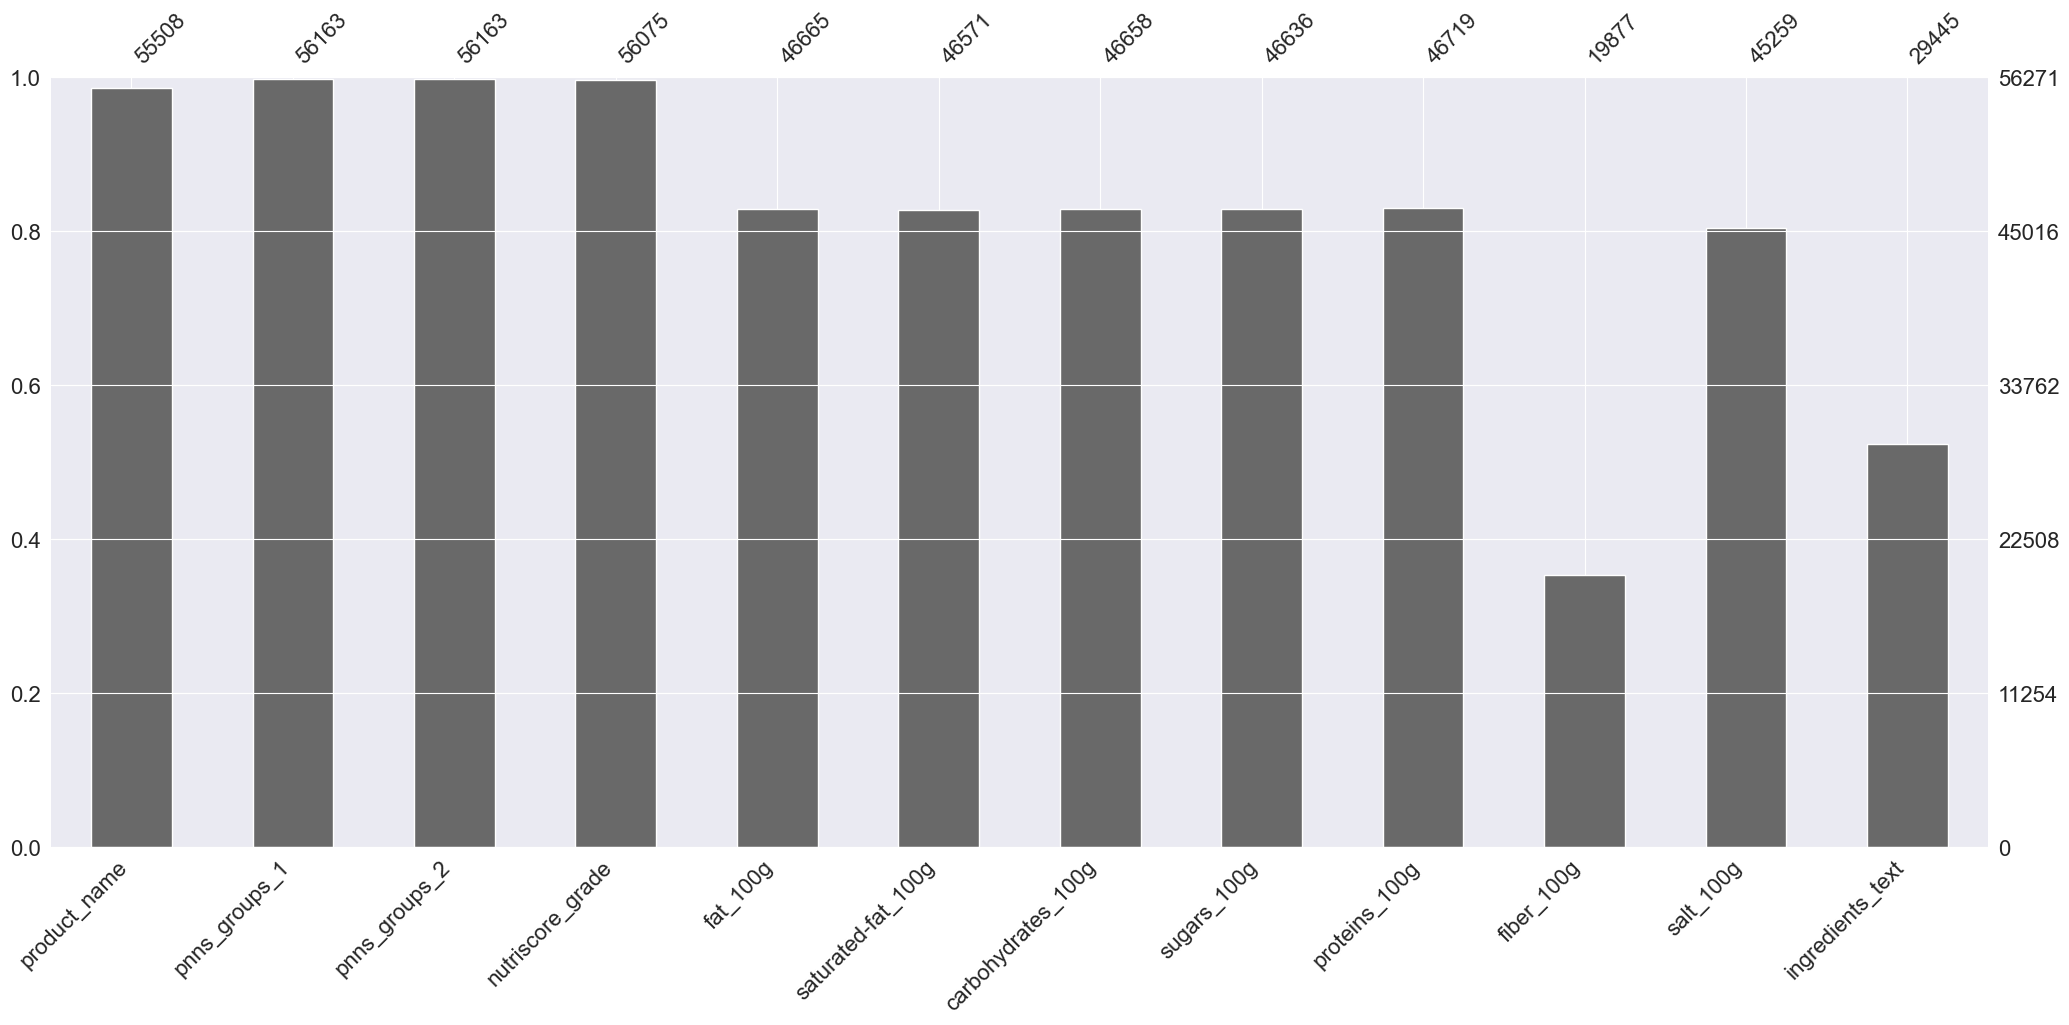

In [13]:
df_cleaned, X, y = analyse_et_nettoyage_auto(dataset)

In [14]:
manquant = df_cleaned.isnull().sum()
pourcentage_manquant = np.round(((manquant / len(df_cleaned)) * 100), 2)

    # Colonnes avec des données manquantes
colonnes_manquantes = manquant[manquant > 0].count()

    # Pourcentage global données manquantes
total_données_manquantes = manquant.sum()
total_pourcentage_manquant = np.round((total_données_manquantes / (len(df_cleaned) * len(df_cleaned.columns)) * 100), 2)

print(total_pourcentage_manquant)

16.26


# 2 : Traitement des outliers

    ## 1. Visualisation des données

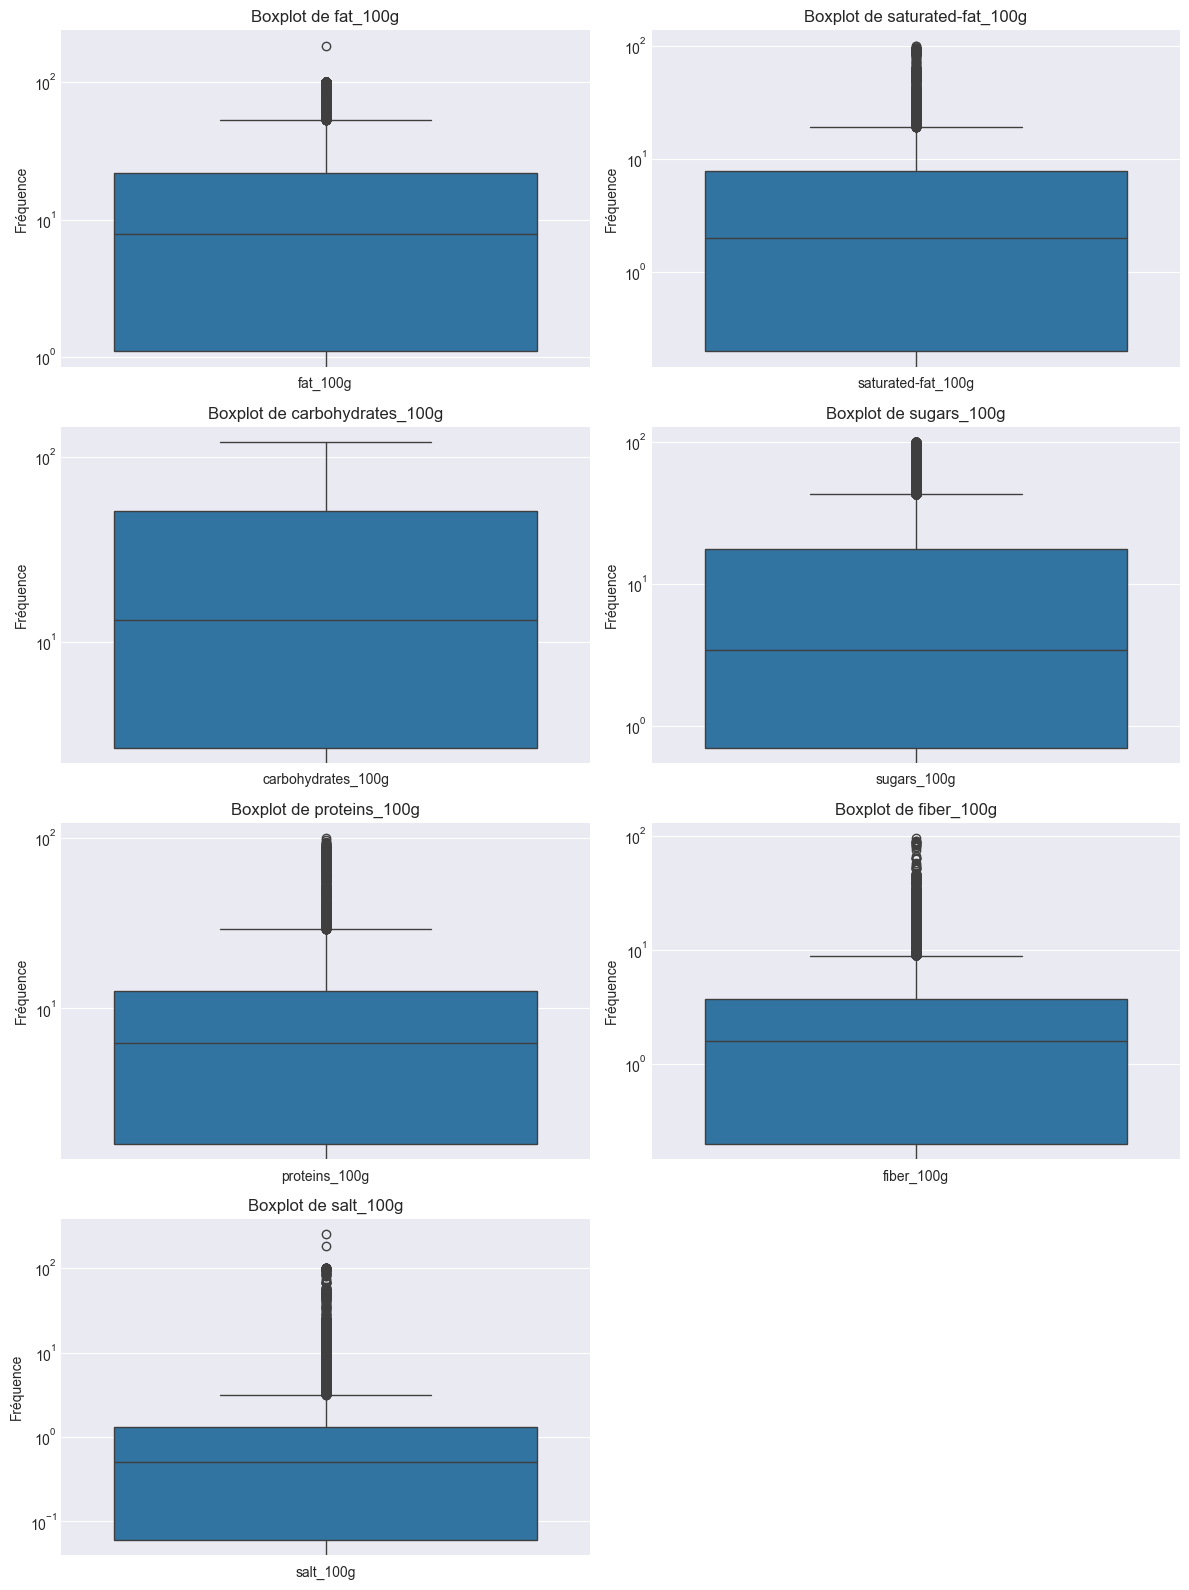

In [15]:
# Filtrer les colonnes contenant "_100g"
colonnes_a_analyser = [c for c in df_cleaned.columns if "_100g" in c]

graphiques(df_cleaned, colonnes_a_analyser, plot_type="boxplot", log=True)

<Axes: xlabel='carbohydrates_100g', ylabel='sugars_100g'>

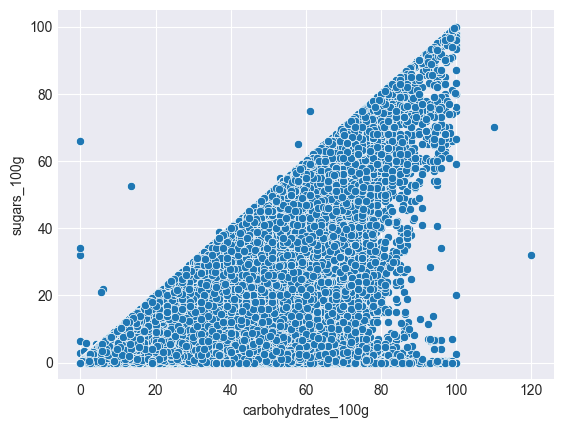

In [16]:
sns.scatterplot(data=df_cleaned, x='carbohydrates_100g', y='sugars_100g')

## 2. Détection des outliers

### 1. Approche orientée métier

In [17]:
colonnes_suspectes = ["proteins_100g", "fat_100g", "carbohydrates_100g", "sugars_100g", "saturated-fat_100g", "salt_100g", "fiber_100g"]

for col in colonnes_suspectes:
    print(f" Top 10 valeurs pour {col}")
    display(
        df_cleaned[["product_name", "pnns_groups_1", col]]
        .sort_values(by=col, ascending=False)
        .head(10)
    )
    print("-" * 50)

df_cleaned[colonnes_suspectes].describe()

 Top 10 valeurs pour proteins_100g


product_name        pnns_groups_1  \
259680                              Vodka Zubrowka 70cL  Alcoholic beverages   
329613  Caramelos duros de café sin azúcar y sin gluten        Sugary snacks   
324868                                         Collagen              unknown   
186237                                      Whey isolat              unknown   
129085         Boissons instantanées - Thé saveur pêche              unknown   
239911      Pulsin' Protéine De Petit Lait Isolée 250 g              unknown   
116739                             Oldschool - Proteine              unknown   
124847                                    Whey Isobolic              unknown   
252154                                       Whey hydro              unknown   
246615                              Whey Native Isolate              unknown   

        proteins_100g  
259680          100.0  
329613           97.0  
324868           95.0  
186237           94.0  
129085           94.0  
239911           93.0  
116739           92.0  
124847           92.0  
252154           91.0  
246615           90.5

--------------------------------------------------
 Top 10 valeurs pour fat_100g


product_name         pnns_groups_1  fat_100g
48909                              PISTACHIOS               unknown     184.0
177743                     Huile d'olive noir        Fat and sauces     100.0
139479                  Maurel huile de colza        Fat and sauces     100.0
233986                       Pumpkin seed oil        Fat and sauces     100.0
234828                     Toasted Sesame Oil  Cereals and potatoes     100.0
198926           Olivenöl Spanien Nativ Extra        Fat and sauces     100.0
131318         Huile d’olive de Nimes bio AOP        Fat and sauces     100.0
245831                    1L Huile Risso'line        Fat and sauces     100.0
364957  Huile d'olive extra vierge ALTO 500ml        Fat and sauces     100.0
129010        Huile de coco biologique vierge        Fat and sauces     100.0

--------------------------------------------------
 Top 10 valeurs pour carbohydrates_100g


product_name          pnns_groups_1  \
48909                           PISTACHIOS                unknown   
175653       Vendée Caramel au beurre salé          Sugary snacks   
352044      Moniegold Chwy TMRND Cndy 95GM          Sugary snacks   
136513                    Sucre enveloppés          Sugary snacks   
144104                           Cassonade          Sugary snacks   
174448                        Noix de coco  Fruits and vegetables   
144005                            Vinaigre         Fat and sauces   
136240  Daddy morceaux brut canne bio 400g          Sugary snacks   
177154        Sucre roux de canne morceaux          Sugary snacks   
173494                         Sucre Glace          Sugary snacks   

        carbohydrates_100g  
48909                120.0  
175653               110.0  
352044               100.0  
136513               100.0  
144104               100.0  
174448               100.0  
144005               100.0  
136240               100.0  
177154               100.0  
173494               100.0

--------------------------------------------------
 Top 10 valeurs pour sugars_100g


product_name  pnns_groups_1  sugars_100g
136513                      Sucre enveloppés  Sugary snacks        100.0
143261                    Sucre en bûchettes  Sugary snacks        100.0
135770                        Sucre de CANNE  Sugary snacks        100.0
135804               Sucre morceaux Sécables  Sugary snacks        100.0
144104                             Cassonade  Sugary snacks        100.0
148235                       Sucre en poudre  Sugary snacks        100.0
195665                  Edulcorants Naturels        unknown        100.0
137627      Sucre en poudre de betterave bio  Sugary snacks        100.0
315226  Azúcar blanco en sobres envase 400 g  Sugary snacks        100.0
137936                                 Sucre  Sugary snacks        100.0

--------------------------------------------------
 Top 10 valeurs pour saturated-fat_100g


product_name   pnns_groups_1  \
143906                   Graisse végétale à frire         unknown   
345613                                 Végétaline  Fat and sauces   
151504  CAUVIN - HUILE VIERGE DE NOIX DE COCO BIO  Fat and sauces   
190105                          Huile De Coco Bio  Fat and sauces   
141060               Huile vierge de noix de coco  Fat and sauces   
182045                       Huile de coco vierge  Fat and sauces   
182352                 Huile de coco extra vierge  Fat and sauces   
177608                          Huile de coco bio  Fat and sauces   
196177                                        NaN  Fat and sauces   
253215                                Coconut oil  Fat and sauces   

        saturated-fat_100g  
143906              100.00  
345613              100.00  
151504               95.00  
190105               95.00  
141060               95.00  
182045               95.00  
182352               94.60  
177608               94.47  
196177               94.20  
253215               94.00

--------------------------------------------------
 Top 10 valeurs pour salt_100g


product_name  pnns_groups_1  \
182123                                            Sel fin        unknown   
135469                  Trio de petits œufs  noir et lait  Sugary snacks   
140350                       Fleur de Sel de Guérande IGP        unknown   
169370                        Fleur de sel de l'ile de ré        unknown   
97271                                 Pure himalayan salt        unknown   
155527                                      Sel au celeri        unknown   
169696  Fleur De Sel De Noirmoutier, 130 Grammes, Marq...        unknown   
167962                             Sel rose de l'Himalaya        unknown   
169724                                       Fleur de sel        unknown   
195020      Sir Winston Tea Tè Verde Deteinato 20 bustine        unknown   

        salt_100g  
182123      250.0  
135469      180.0  
140350      100.0  
169370      100.0  
97271       100.0  
155527      100.0  
169696      100.0  
167962      100.0  
169724      100.0  
195020      100.0

--------------------------------------------------
 Top 10 valeurs pour fiber_100g


product_name  \
254148                                 Flocons 5 Céréales   
77450                                     Psyllium powder   
230314                                  Pappadums naturel   
169502                          Flacon Cristaux He Menthe   
135555                                    Fibres & stévia   
188130                    Téguments de Psyllium blond 99%   
176907                          Téguments de Psyllium Bio   
143518                                      Bettraves bio   
239877                                  Xanthan Gum, E415   
245836  Agar-Agar - Gélifiant végétal à base d'algues ...   

                pnns_groups_1  fiber_100g  
254148   Cereals and potatoes        96.0  
77450                 unknown        91.0  
230314   Cereals and potatoes        91.0  
169502                unknown        89.0  
135555          Sugary snacks        88.4  
188130                unknown        88.2  
176907                unknown        88.0  
143518  Fruits and vegetables        85.0  
239877                unknown        85.0  
245836         Fish Meat Eggs        83.3

--------------------------------------------------


proteins_100g      fat_100g  carbohydrates_100g   sugars_100g  \
count   43794.000000  43738.000000        43734.000000  43688.000000   
mean        8.785836     14.252116           26.542954     13.159050   
std         9.609637     18.016579           27.410073     19.589303   
min         0.000000      0.000000            0.000000      0.000000   
25%         1.600000      1.100000            2.700000      0.700000   
50%         6.300000      7.800000           13.200000      3.400000   
75%        12.635000     22.000000           51.000000     17.600000   
max       100.000000    184.000000          120.000000    100.000000   

       saturated-fat_100g     salt_100g    fiber_100g  
count        43607.000000  42460.000000  19366.000000  
mean             5.406197      1.164685      3.021700  
std              8.171547      4.236645      5.124883  
min              0.000000      0.000000      0.000000  
25%              0.200000      0.060000      0.200000  
50%              2.000000      0.510000      1.600000  
75%              7.800000      1.300000      3.700000  
max            100.000000    250.000000     96.000000

On observe plusieurs valeurs qui dépassent le seuil maximum des produits. Nous allons donc les traiter de plusieurs manières différentes. Nous allons instaurer un seuil maximum pour chaque valeur nutritionnelle qui sera de 100g. Nous allons aussi utiliser la méthode KNN pour remplacer les valeurs extrêmes par des valeurs plus normales. Si jamais des outliers seraient des erreurs manifestes, alors là elles seront simplement retirées du jeu de données.

### 2. Approche Statistique

On utilise les écarts interquartiles pour détecter des outliers.

In [18]:
df_cleaned['fat_100g'].describe()

count    43738.000000
mean        14.252116
std         18.016579
min          0.000000
25%          1.100000
50%          7.800000
75%         22.000000
max        184.000000
Name: fat_100g, dtype: float64

In [19]:
outliers_detected = outliers_iqr(df_cleaned, colonnes_suspectes)
for col, df_outliers in outliers_detected.items():
    print(f"\n Outliers détectés pour {col} :")
    display(df_outliers.sort_values(by=col, ascending=False).head(10))


 proteins_100g - IQR: 11.035, Bornes: [-14.952500000000002, 29.1875]

 fat_100g - IQR: 20.9, Bornes: [-30.249999999999996, 53.349999999999994]

 carbohydrates_100g - IQR: 48.3, Bornes: [-69.74999999999999, 123.44999999999999]

 sugars_100g - IQR: 16.900000000000002, Bornes: [-24.650000000000002, 42.95]

 saturated-fat_100g - IQR: 7.6, Bornes: [-11.2, 19.2]

 salt_100g - IQR: 1.24, Bornes: [-1.7999999999999998, 3.16]

 fiber_100g - IQR: 3.5, Bornes: [-5.05, 8.95]

 Outliers détectés pour proteins_100g :


proteins_100g                                     product_name
259680          100.0                              Vodka Zubrowka 70cL
329613           97.0  Caramelos duros de café sin azúcar y sin gluten
324868           95.0                                         Collagen
186237           94.0                                      Whey isolat
129085           94.0         Boissons instantanées - Thé saveur pêche
239911           93.0      Pulsin' Protéine De Petit Lait Isolée 250 g
116739           92.0                             Oldschool - Proteine
124847           92.0                                    Whey Isobolic
252154           91.0                                       Whey hydro
246615           90.5                              Whey Native Isolate


 Outliers détectés pour fat_100g :


fat_100g                                       product_name
48909      184.0                                         PISTACHIOS
4367       100.0                         Huile de noix de coco pure
161287     100.0                 Huile extra vierge de noix de coco
161332     100.0                    Huile Vierge Chanvre Bio France
161429     100.0         Huile d’olive aromatisée a la truffe noire
162139     100.0                             Huile vierge de sésame
162301     100.0                             100% huile deTournesol
162517     100.0                          Huile vierge de colza bio
162612     100.0  Huile De Sésame Première Pression à Froid Bio ...
162847     100.0                                     Huiles d'olive


 Outliers détectés pour carbohydrates_100g :


Empty DataFrame
Columns: [carbohydrates_100g, product_name]
Index: []


 Outliers détectés pour sugars_100g :


sugars_100g                                      product_name
184189        100.0                           Sucre de canne roux bio
135127        100.0  Boite de bûchettes 4g canne blond bio daddy 300g
319244        100.0                                   Sucre en poudre
144104        100.0                                         Cassonade
144005        100.0                                          Vinaigre
355955        100.0                                    bio-rohrzucker
321445        100.0                    Azucar Moreno Integral de Caña
159571        100.0                                             Sucre
132473        100.0                                   Sucre en poudre
249509        100.0                                    Sucre morceaux


 Outliers détectés pour saturated-fat_100g :


saturated-fat_100g                               product_name
345613              100.00                                 Végétaline
143906              100.00                   Graisse végétale à frire
141060               95.00               Huile vierge de noix de coco
151504               95.00  CAUVIN - HUILE VIERGE DE NOIX DE COCO BIO
190105               95.00                          Huile De Coco Bio
182045               95.00                       Huile de coco vierge
182352               94.60                 Huile de coco extra vierge
177608               94.47                          Huile de coco bio
196177               94.20                                        NaN
216056               94.00                        Organic Coconut Oil


 Outliers détectés pour salt_100g :


salt_100g                                   product_name
182123      250.0                                        Sel fin
135469      180.0              Trio de petits œufs  noir et lait
195020      100.0  Sir Winston Tea Tè Verde Deteinato 20 bustine
170414      100.0                       Fleur de Sel de Camargue
183530      100.0                       Fleur de Sel de Gruissan
140350      100.0                   Fleur de Sel de Guérande IGP
155527      100.0                                  Sel au celeri
144948      100.0                               Sel de Table Fin
97271       100.0                            Pure himalayan salt
151840      100.0                    Fleur De Sel De L'île De Ré


 Outliers détectés pour fiber_100g :


fiber_100g                                       product_name
254148        96.0                                 Flocons 5 Céréales
77450         91.0                                    Psyllium powder
230314        91.0                                  Pappadums naturel
169502        89.0                          Flacon Cristaux He Menthe
135555        88.4                                    Fibres & stévia
188130        88.2                    Téguments de Psyllium blond 99%
176907        88.0                          Téguments de Psyllium Bio
143518        85.0                                      Bettraves bio
239877        85.0                                  Xanthan Gum, E415
245836        83.3  Agar-Agar - Gélifiant végétal à base d'algues ...

In [20]:
df_cleaned['carbohydrates_100g'].describe()

count    43734.000000
mean        26.542954
std         27.410073
min          0.000000
25%          2.700000
50%         13.200000
75%         51.000000
max        120.000000
Name: carbohydrates_100g, dtype: float64

## 3. Traitement des valeurs aberrantes

Nous allons instaurer un seuil maximum pour chaque valeur nutritionnelle qui sera de 100g.

In [21]:
valeurs_suspectes_par_colonne = (df_cleaned[colonnes_suspectes] > 100).sum()
print(valeurs_suspectes_par_colonne)

proteins_100g         0
fat_100g              1
carbohydrates_100g    2
sugars_100g           0
saturated-fat_100g    0
salt_100g             2
fiber_100g            0
dtype: int64


In [22]:
# Je supprime ceux ci aussi car il ont 100 et 97 en valeur dans proteins_100g, ce qui n'est pas normal.
i = df_cleaned.loc[df_cleaned["product_name"].isin(["Vodka Zubrowka 70cL", "Caramelos duros de café sin azúcar y sin gluten","Vinaigre"])].index
df_cleaned = df_cleaned.drop(i)

In [23]:
# Ajout du seuil maximum
df_cleaned = df_cleaned.drop(df_cleaned[(df_cleaned[colonnes_suspectes] > 100).any(axis=1)].index)

In [24]:
print("Valeurs extrêmes APRÈS application du seuil :")
df_cleaned[colonnes_suspectes].describe()

Valeurs extrêmes APRÈS application du seuil :


proteins_100g      fat_100g  carbohydrates_100g   sugars_100g  \
count   43787.000000  43731.000000        43727.000000  43681.000000   
mean        8.778948     14.248578           26.538627     13.155573   
std         9.579128     17.998690           27.402478     19.583627   
min         0.000000      0.000000            0.000000      0.000000   
25%         1.600000      1.100000            2.700000      0.700000   
50%         6.300000      7.800000           13.200000      3.400000   
75%        12.600000     22.000000           51.000000     17.600000   
max        95.000000    100.000000          100.000000    100.000000   

       saturated-fat_100g     salt_100g    fiber_100g  
count        43600.000000  42453.000000  19365.000000  
mean             5.405528      1.154639      3.019791  
std              8.170882      3.967344      5.118121  
min              0.000000      0.000000      0.000000  
25%              0.200000      0.060000      0.200000  
50%              2.000000      0.510000      1.600000  
75%              7.800000      1.300000      3.700000  
max            100.000000    100.000000     96.000000

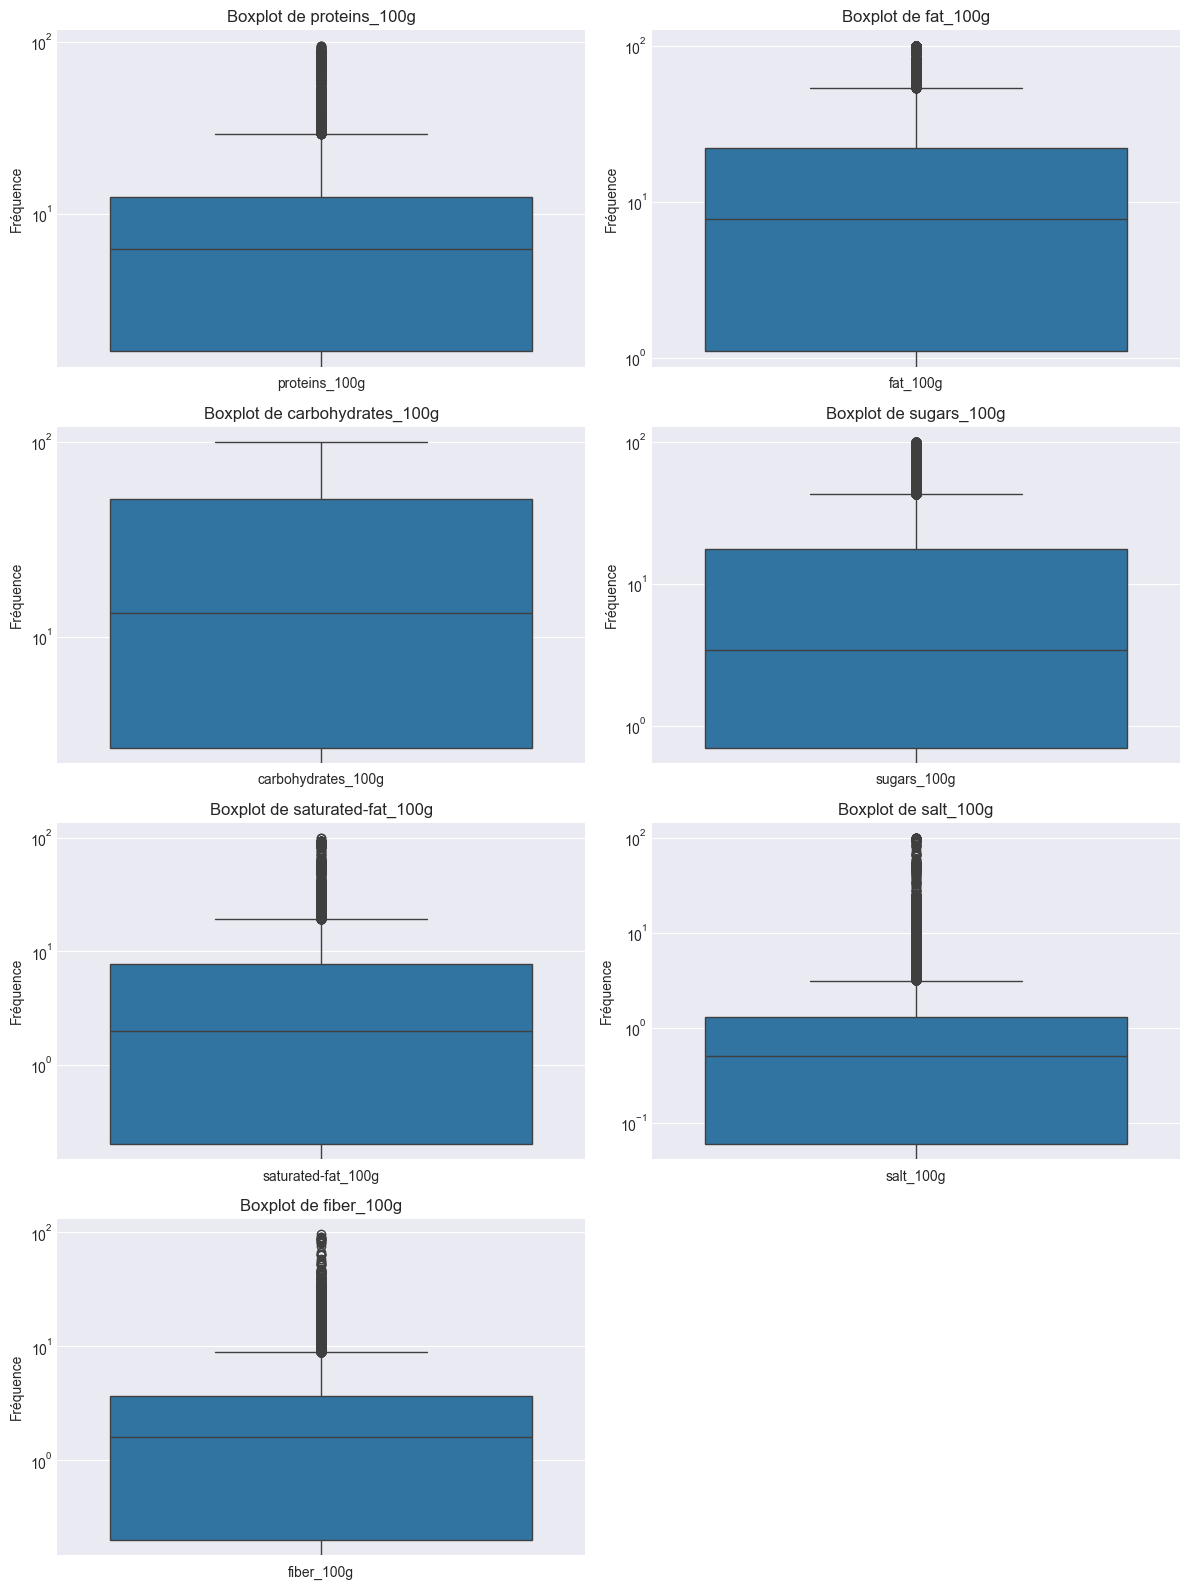

In [25]:
graphiques(df_cleaned, colonnes_suspectes, plot_type="boxplot", log=True)

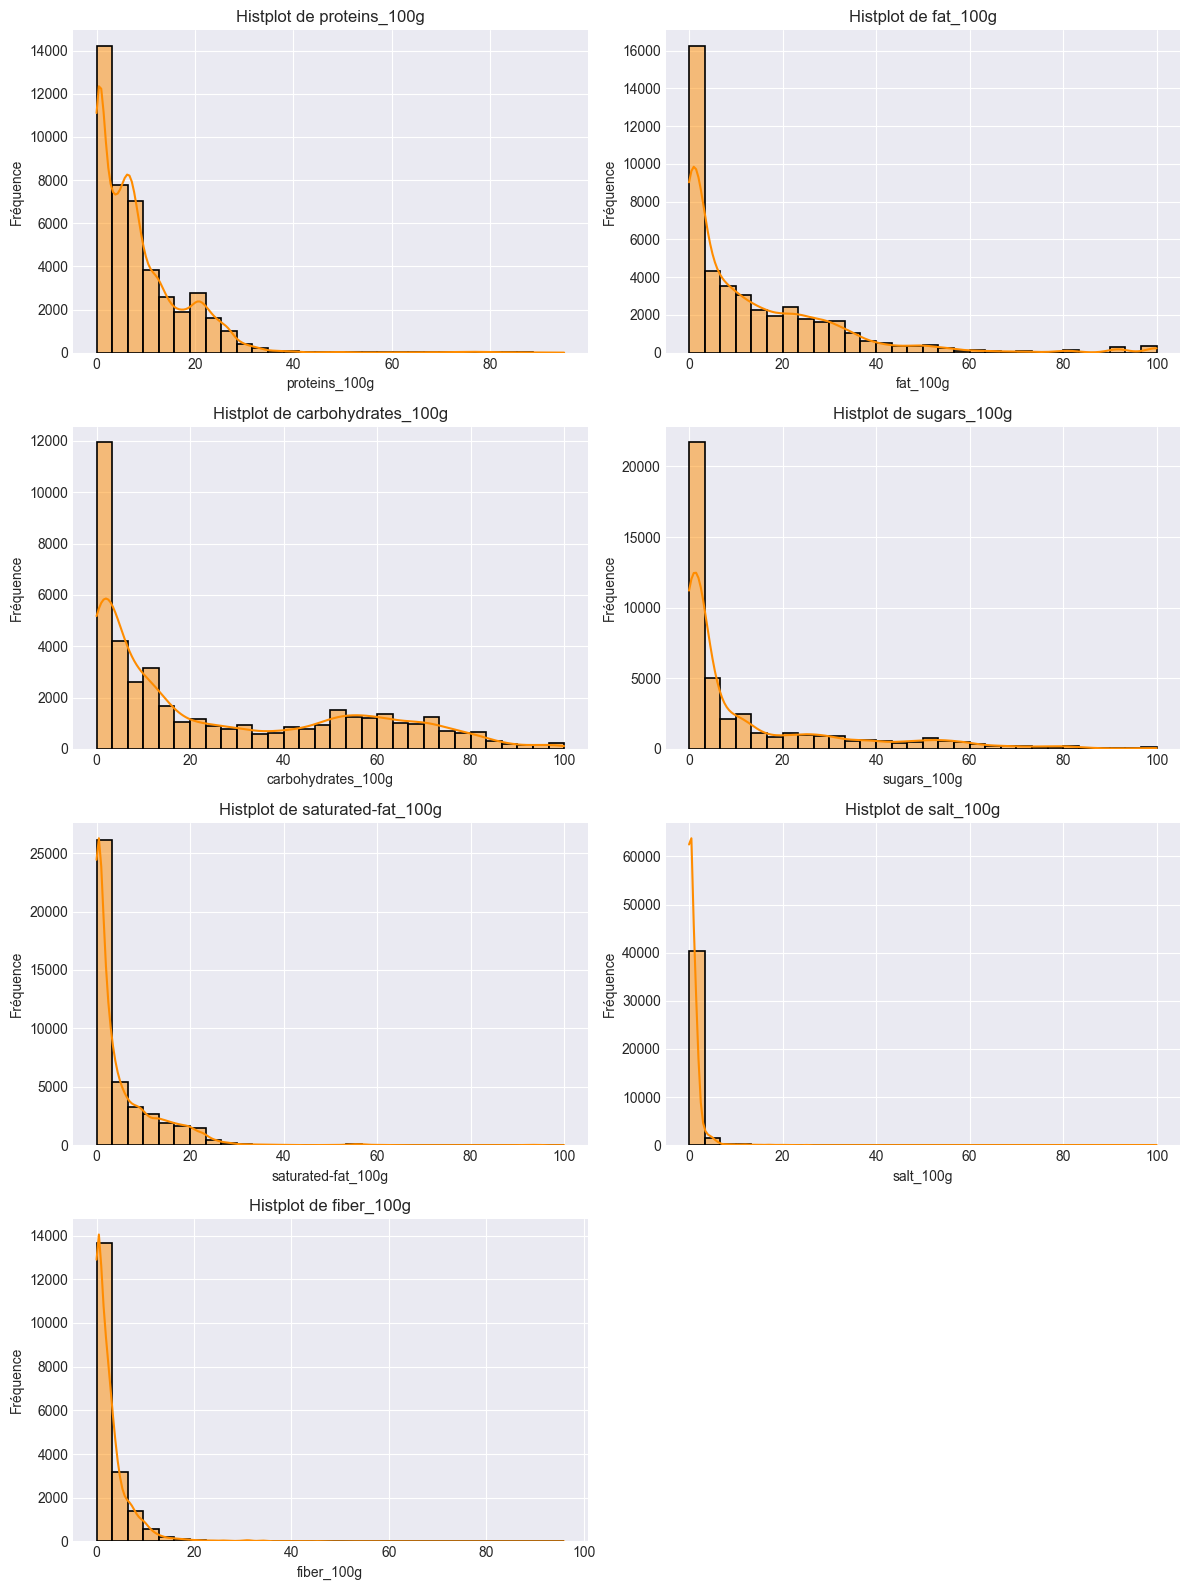

In [26]:
graphiques(df_cleaned, colonnes_suspectes, plot_type="histplot")

# 3 : Traitement des valeurs manquantes

<Axes: >

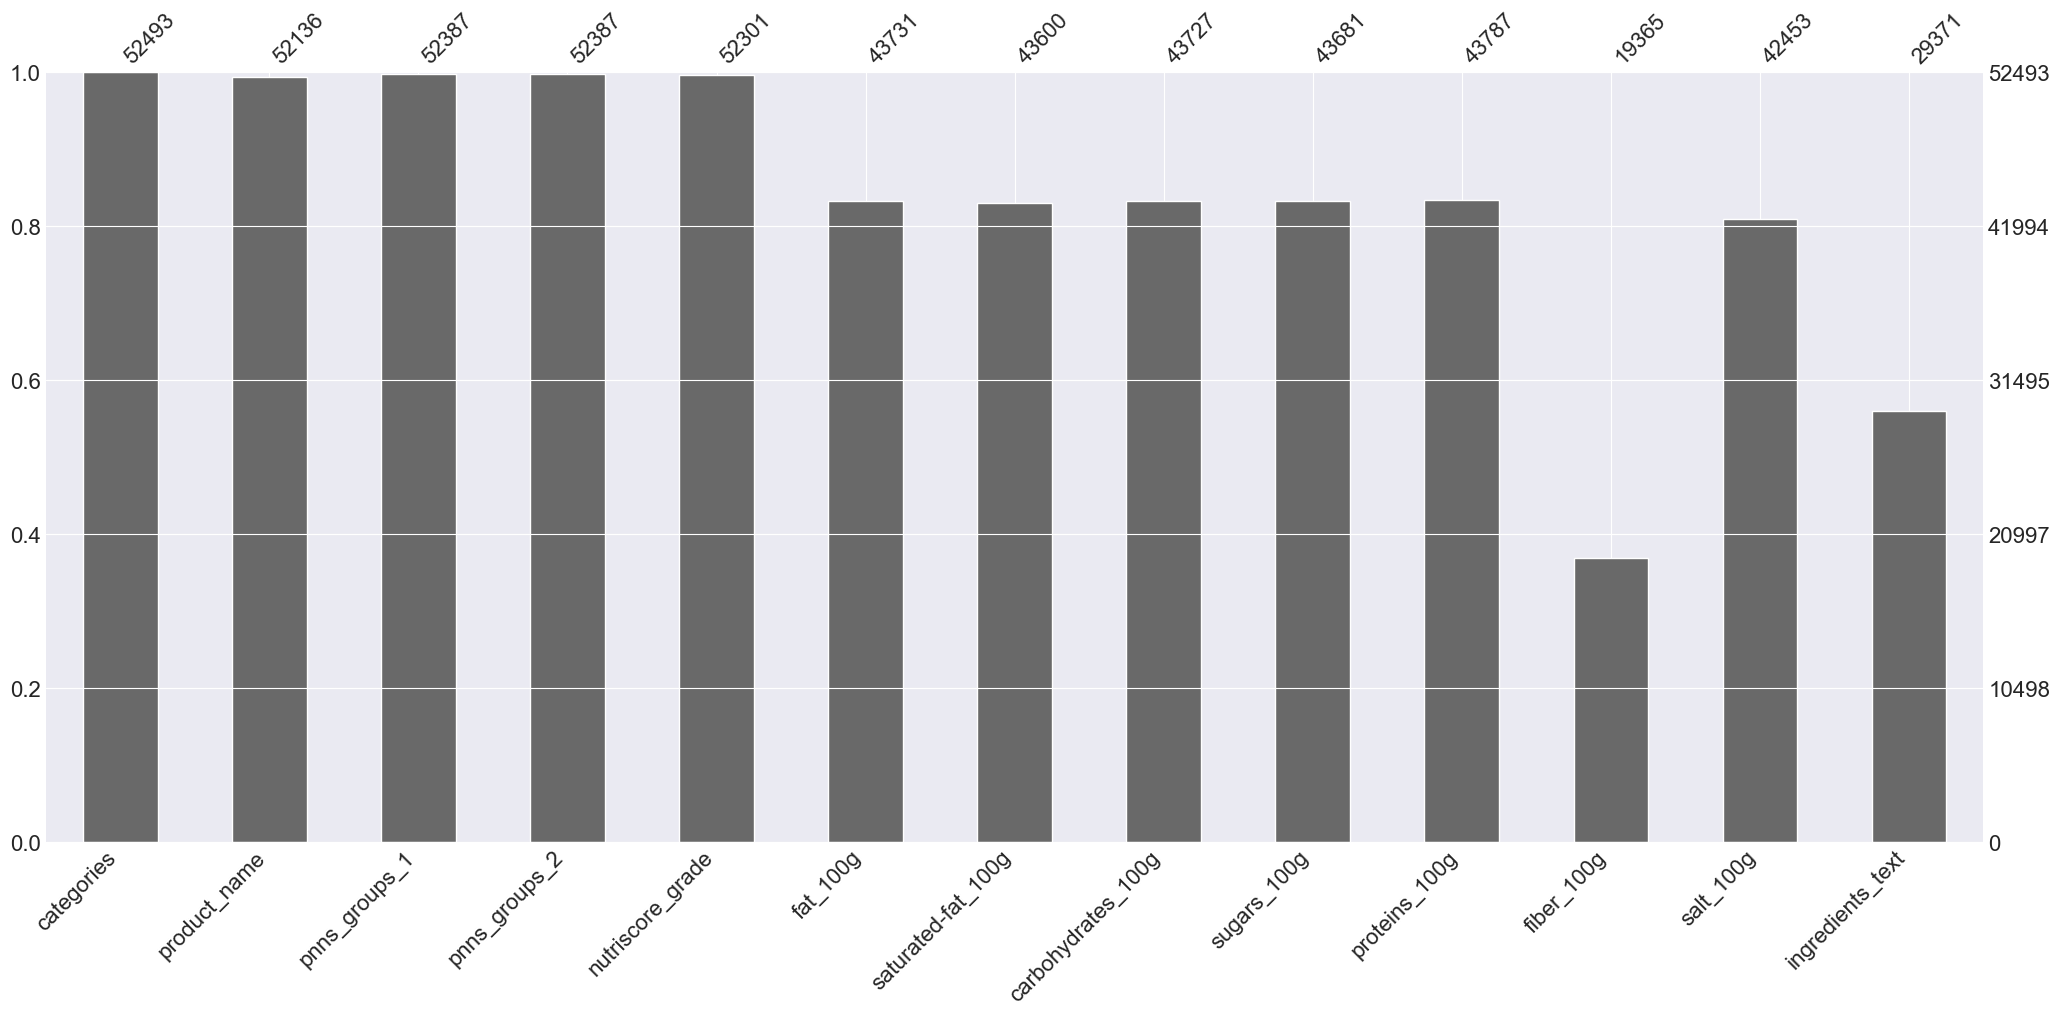

In [27]:
msno.bar(df_cleaned)

## 1. Imputation des valeurs manquantes par 0

Il peut arriver que les utilisateurs ne remplissent pas toutes les colonnes, seulement celles où le produit contient des valeurs. Donc certaines valeurs manquantes ne sont pas vraiment des valeurs manquantes mais plus des 0 induits. Il va donc falloir différencier ces deux NaN et imputer par 0 les NaN concernés.

In [28]:
df_cleaned['total_nutriments'] = df_cleaned[["proteins_100g", "fat_100g", "carbohydrates_100g", "fiber_100g", "salt_100g"]].sum(axis=1, min_count=1)
print('Description de total_nutriments:')
df_cleaned['total_nutriments'].describe()

Description de total_nutriments:


count    44220.000000
mean        51.457690
std         31.899088
min          0.000000
25%         24.277500
50%         47.100000
75%         84.700000
max        265.000000
Name: total_nutriments, dtype: float64

In [29]:
for col in colonnes_suspectes:
    df_cleaned.loc[
        (df_cleaned['total_nutriments'] >= 99.9) & (df_cleaned[col].isna()), col
    ] = 0

<Axes: >

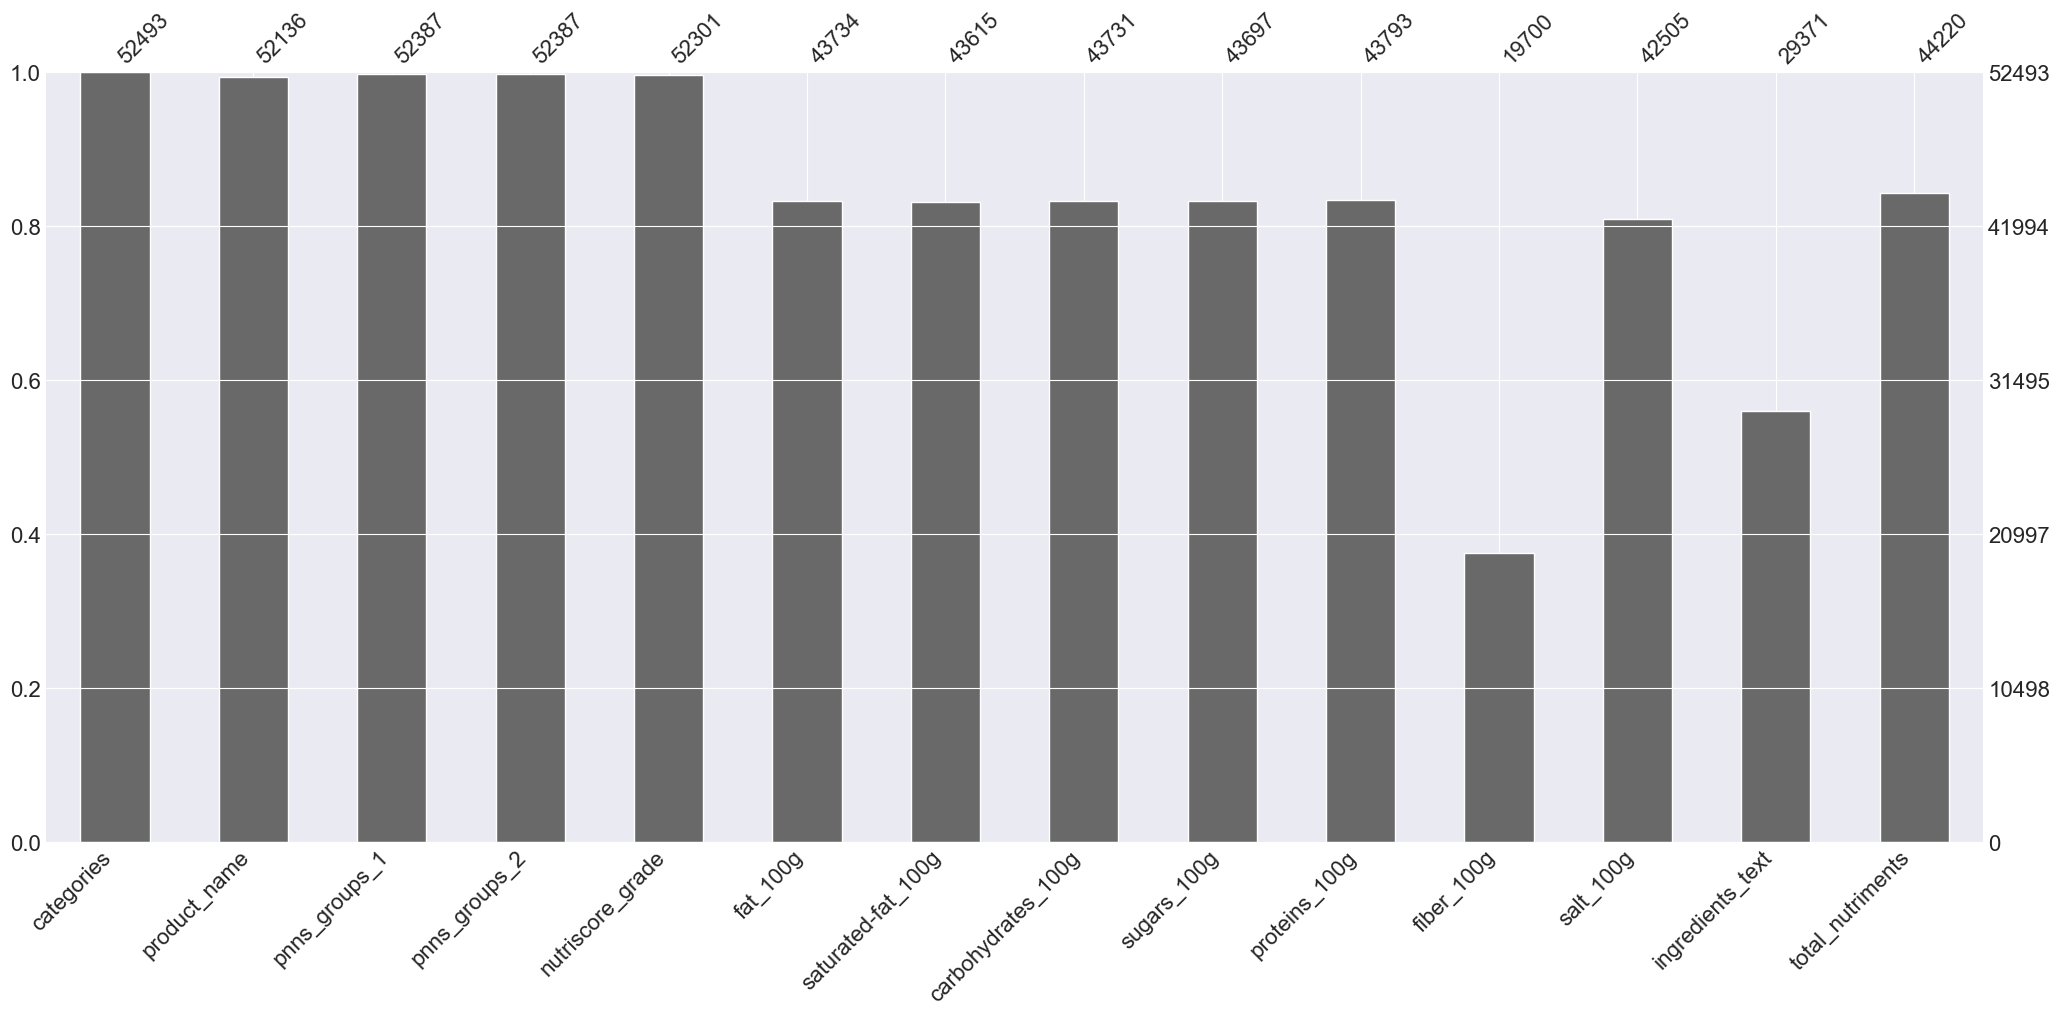

In [30]:
msno.bar(df_cleaned)

In [31]:
colonnes = ['product_name', 'total_nutriments'] + colonnes_suspectes

produits_anormaux = df_cleaned[df_cleaned["total_nutriments"] > 105][colonnes]
print("🔎 Produits avec total_nutriments > 105 g/100g :")
produits_anormaux.sort_values(by="total_nutriments", ascending=False)

🔎 Produits avec total_nutriments > 105 g/100g :


product_name  total_nutriments  \
147421                            miettes de thon           265.000   
135555                            Fibres & stévia           184.376   
230314                          Pappadums naturel           175.200   
254148                         Flocons 5 Céréales           174.210   
238588                       Protéine de riz brun           163.900   
...                                           ...               ...   
139881  Amandes Grillées à Sec - Extra Croquantes           105.100   
251182                                   Gressins           105.080   
200770  Snack balls figues, graines de chia, noix           105.030   
129540                       Amandes décortiquées           105.010   
123012  Amandes décortiquées (variété non pareil)           105.010   

        proteins_100g  fat_100g  carbohydrates_100g  sugars_100g  \
147421           34.0      95.0                 4.0          0.0   
135555            0.0       0.0                95.9          4.0   
230314           18.0      25.0                38.0          1.1   
254148           11.6       3.5                63.1          1.5   
238588           78.0       2.1                 3.8          1.0   
...               ...       ...                 ...          ...   
139881           21.0      50.0                21.0          4.7   
251182           15.5      13.8                75.0          3.2   
200770            6.2       8.8                69.0         30.0   
129540           21.1      49.9                21.5          6.2   
123012           21.1      49.9                21.5          4.2   

        saturated-fat_100g  salt_100g  fiber_100g  
147421                78.0     67.000        65.0  
135555                 0.0      0.076        88.4  
230314                 2.1      3.200        91.0  
254148                 0.6      0.010        96.0  
238588                 0.4      0.000        80.0  
...                    ...        ...         ...  
139881                 3.8      1.100        12.0  
251182                 4.0      0.780         0.0  
200770                 1.0      0.030        21.0  
129540                 3.8      0.010        12.5  
123012                 3.8      0.010        12.5  

[143 rows x 9 columns]

In [32]:
produits_anormaux.describe()

total_nutriments  proteins_100g    fat_100g  carbohydrates_100g  \
count        143.000000     143.000000  143.000000          143.000000   
mean         117.676320      16.088808   25.436492           50.594665   
std           19.714930      14.038385   22.457136           26.354608   
min          105.010000       0.000000    0.000000            0.000000   
25%          106.566650       6.735000    4.400000           26.650000   
50%          110.800001      12.300000   18.000000           54.000000   
75%          122.215000      21.100000   42.500000           70.000000   
max          265.000000      78.000000   95.000000          100.000000   

       sugars_100g  saturated-fat_100g   salt_100g  fiber_100g  
count   143.000000          143.000000  143.000000   143.00000  
mean     18.817127            9.293754    5.232215    20.32414  
std      23.465745           15.058163   14.078286    19.45879  
min       0.000000            0.000000    0.000000     0.00000  
25%       3.050000            0.700000    0.015000     8.08000  
50%       7.100000            3.700000    0.323000    13.00000  
75%      26.950000           10.000000    1.916667    29.99500  
max     100.000000           78.000000   90.000000    96.00000

In [33]:
nb_avant = len(df_cleaned)
df_cleaned = df_cleaned.drop(df_cleaned[df_cleaned['total_nutriments'] > 105].index)
nb_apres = len(df_cleaned)

print(f"🗑️ Nombre de lignes supprimées : {nb_avant - nb_apres}")

🗑️ Nombre de lignes supprimées : 143


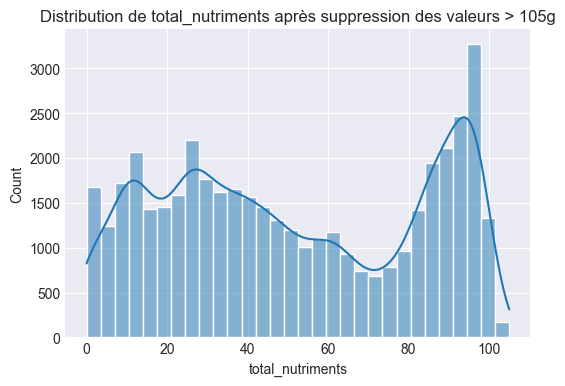

In [34]:
plt.figure(figsize=(6, 4))
sns.histplot(df_cleaned["total_nutriments"], bins=30, kde=True)
plt.title("Distribution de total_nutriments après suppression des valeurs > 105g")
plt.show()

<Axes: >

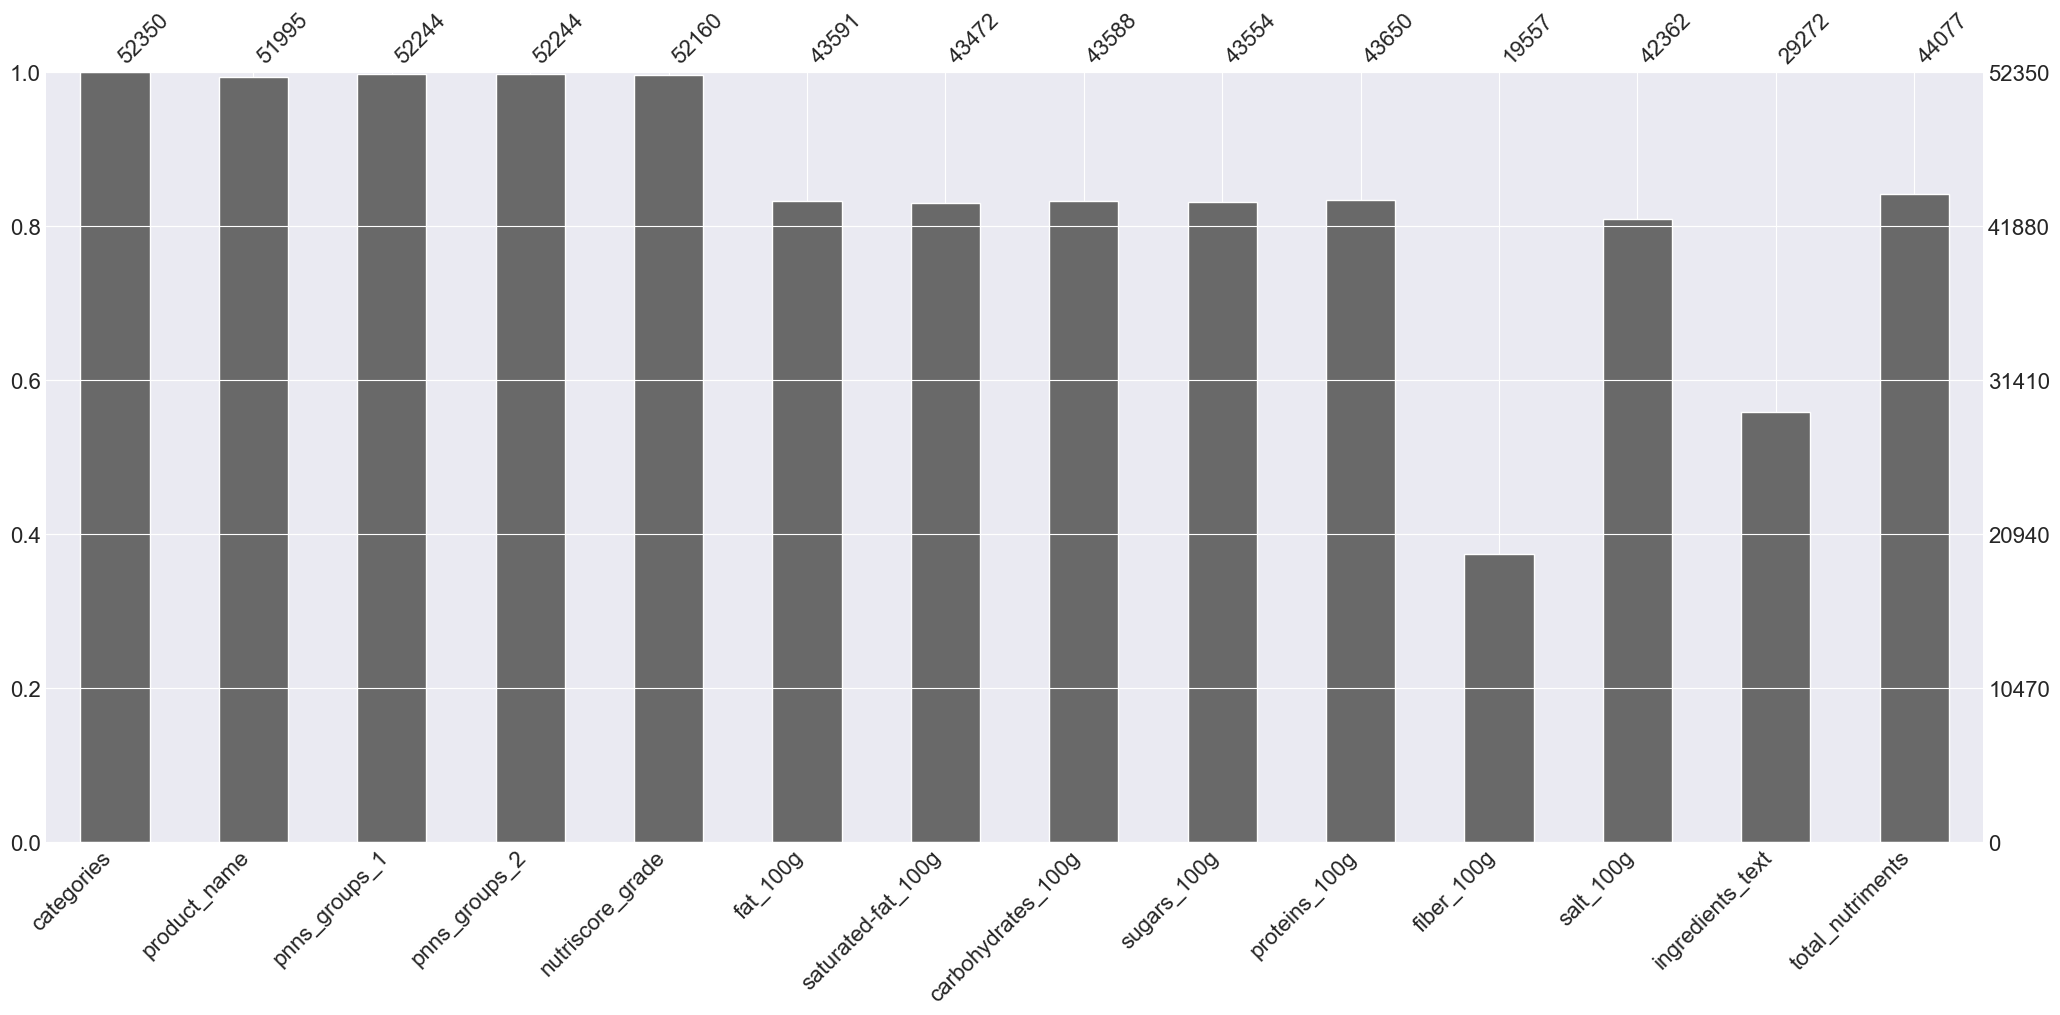

In [35]:
msno.bar(df_cleaned)

## 2. Imputation des valeurs par KNN

In [36]:
file_scaled = "df_scaled.csv"

In [37]:
if os.path.exists(file_scaled):
    print("📂 Chargement des données imputées avec KNN")
    df_scaled = pd.read_csv(file_scaled)
    df_scaled[colonnes_suspectes] = df_scaled[colonnes_suspectes].apply(pd.to_numeric)  # Conversion en numérique
    scaler = load('scaler.joblib')
    df_cleaned[colonnes_suspectes] = scaler.inverse_transform(df_scaled[colonnes_suspectes])
else:
    print("🔄 Exécution de l'imputation KNN")
    scaler = StandardScaler()
    df_scaled = df_cleaned.copy()
    df_scaled[colonnes_suspectes] = scaler.fit_transform(df_scaled[colonnes_suspectes])
    dump(scaler, 'scaler.joblib')
    imputer = KNNImputer(n_neighbors=5)
    df_scaled[colonnes_suspectes] = imputer.fit_transform(df_scaled[colonnes_suspectes])
    df_scaled.to_csv(file_scaled, index=False)
    df_cleaned[colonnes_suspectes] = scaler.inverse_transform(df_scaled[colonnes_suspectes])

📂 Chargement des données imputées avec KNN


## 3. Vérification des valeurs

In [38]:
# On enlève les produits sans nom
df_cleaned.dropna(subset=['product_name'], inplace=True)

In [39]:
df_cleaned['product_name'] = df_cleaned['product_name'].replace('nan', None)
df_cleaned.dropna(subset=['product_name'], inplace=True)

In [40]:
print(df_cleaned["product_name"].isna().sum())

0


In [41]:
df_cleaned.to_csv('df_final.csv', index=False)

<Axes: >

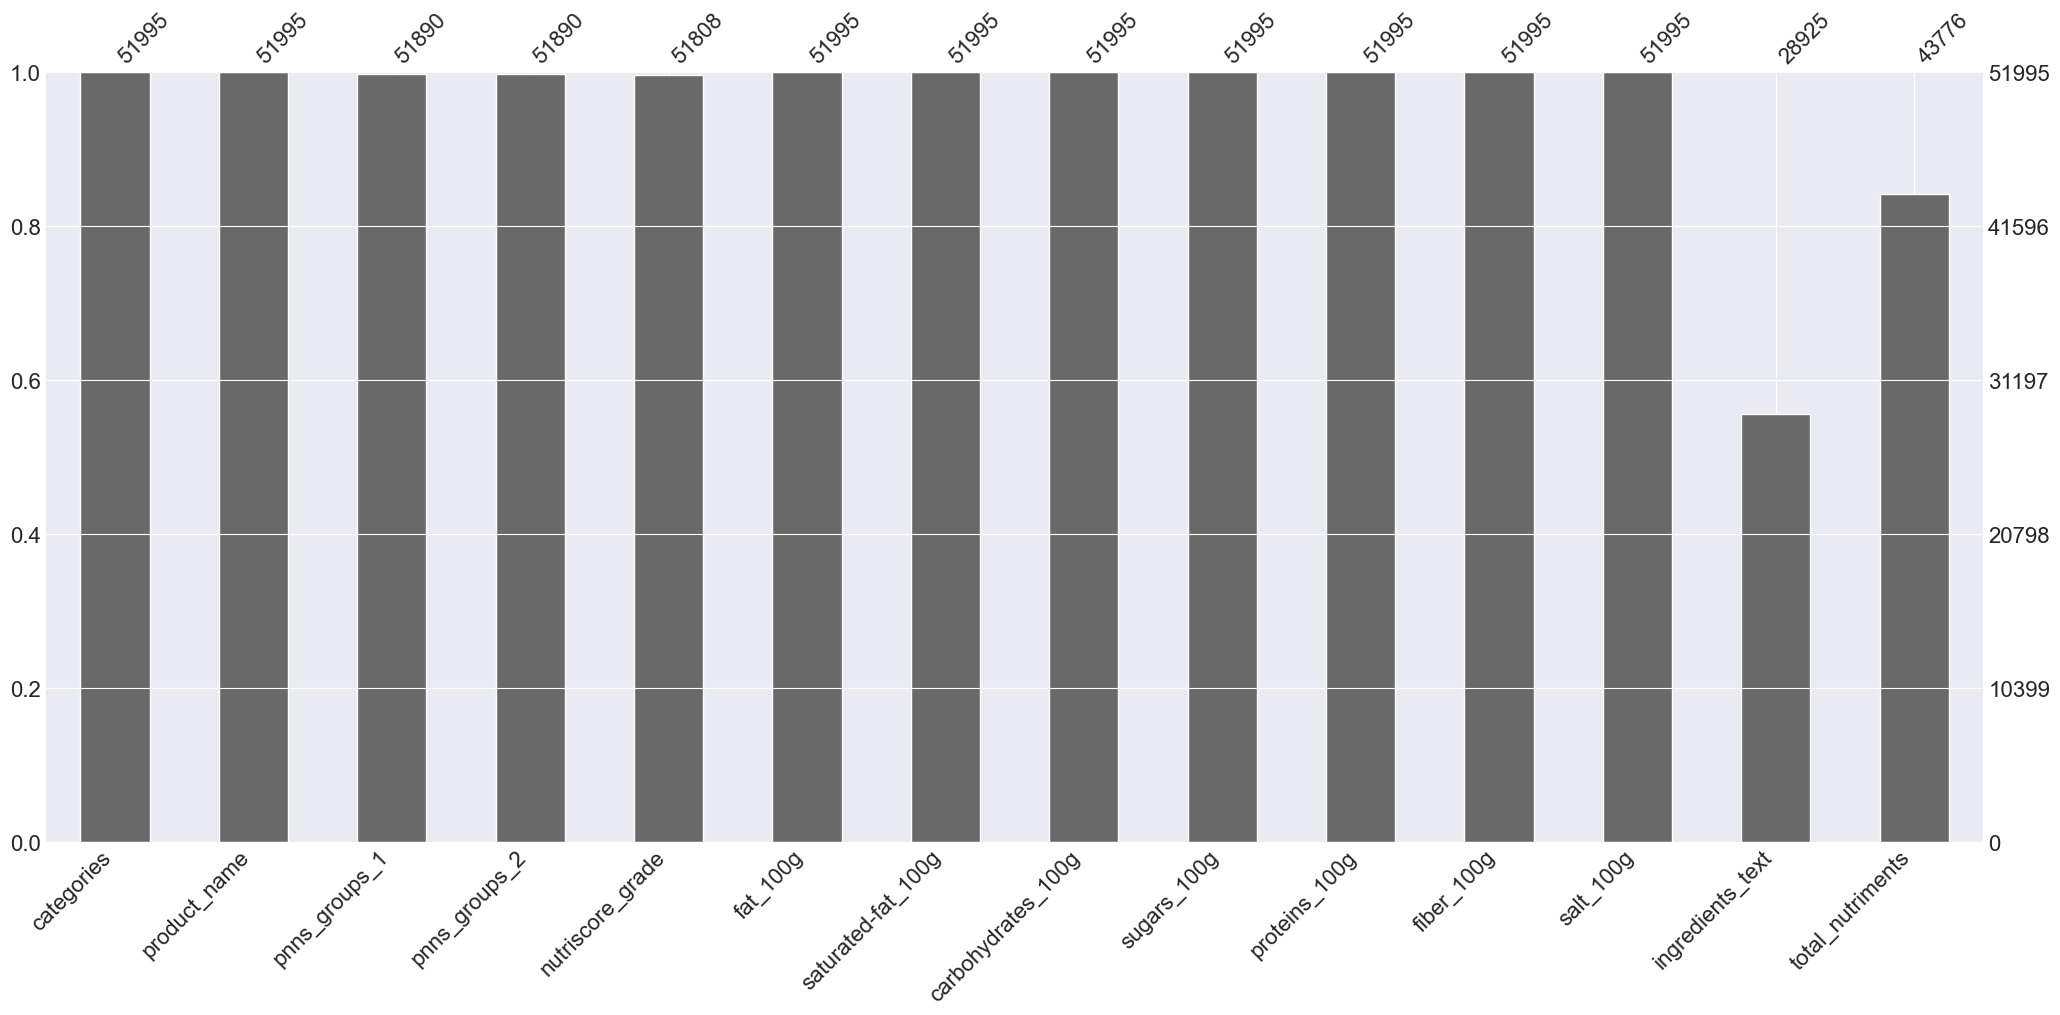

In [42]:
msno.bar(df_cleaned)

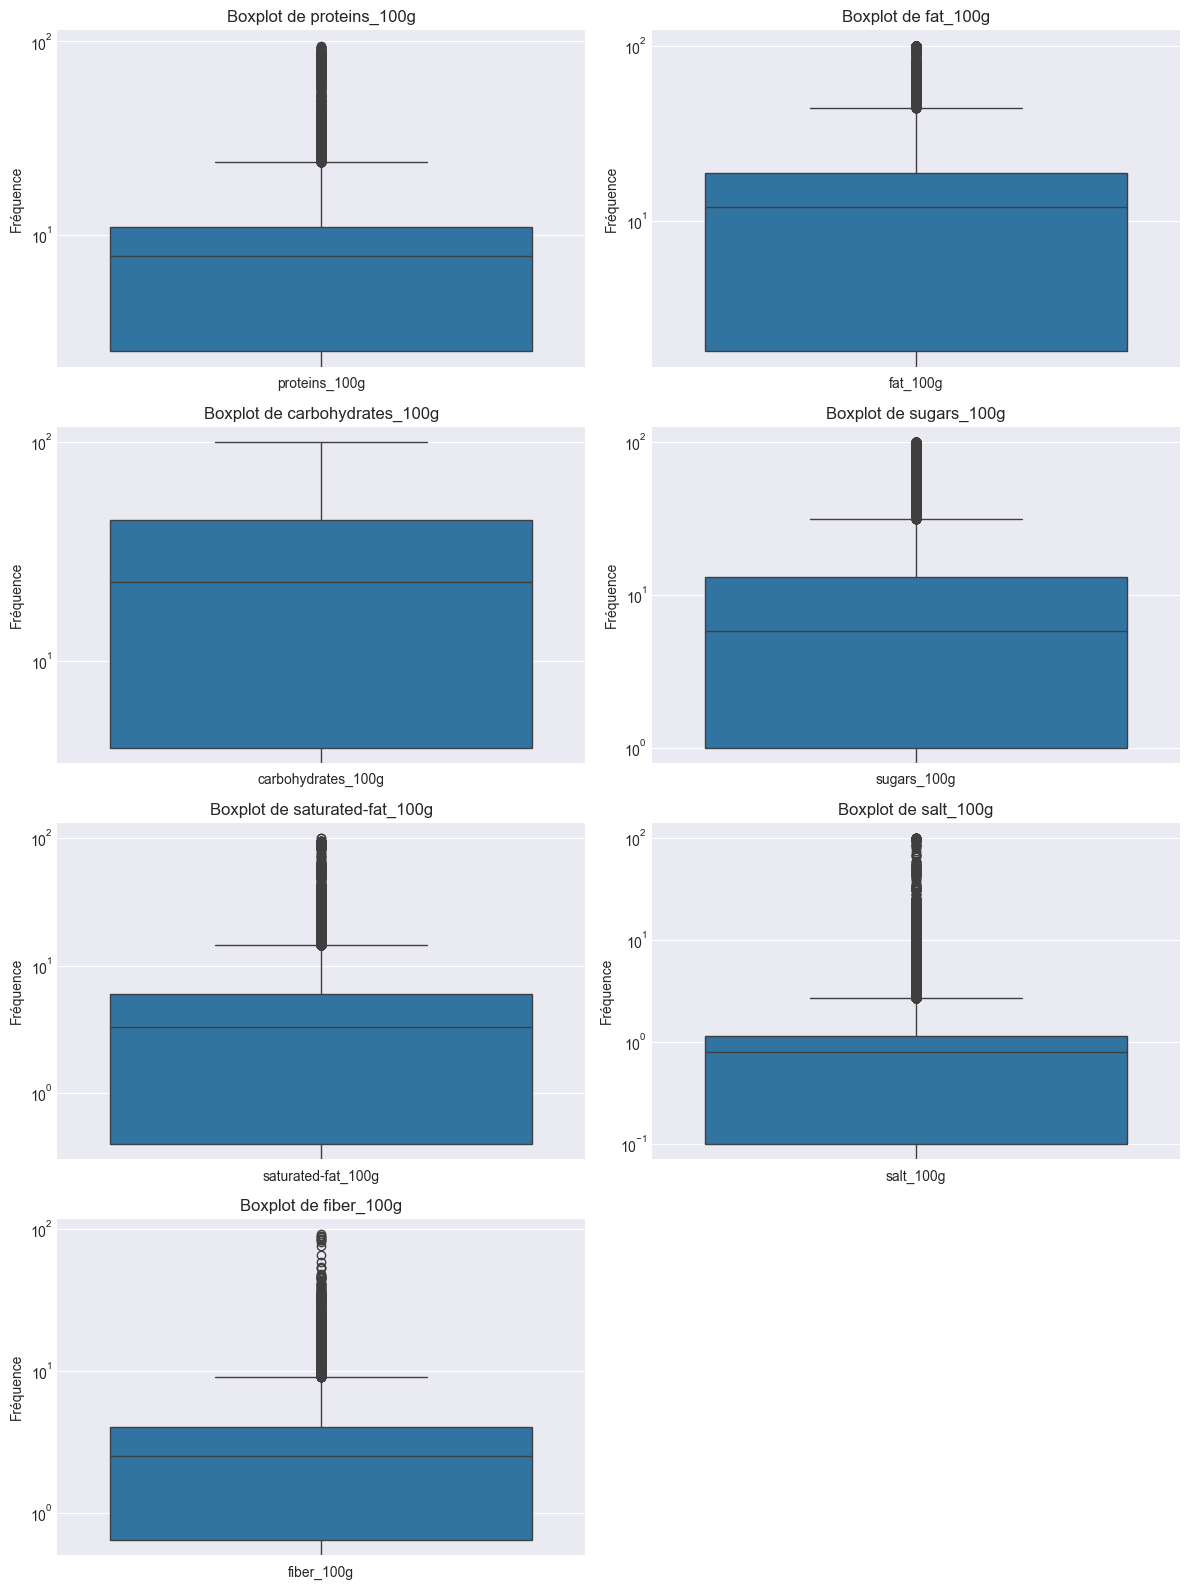

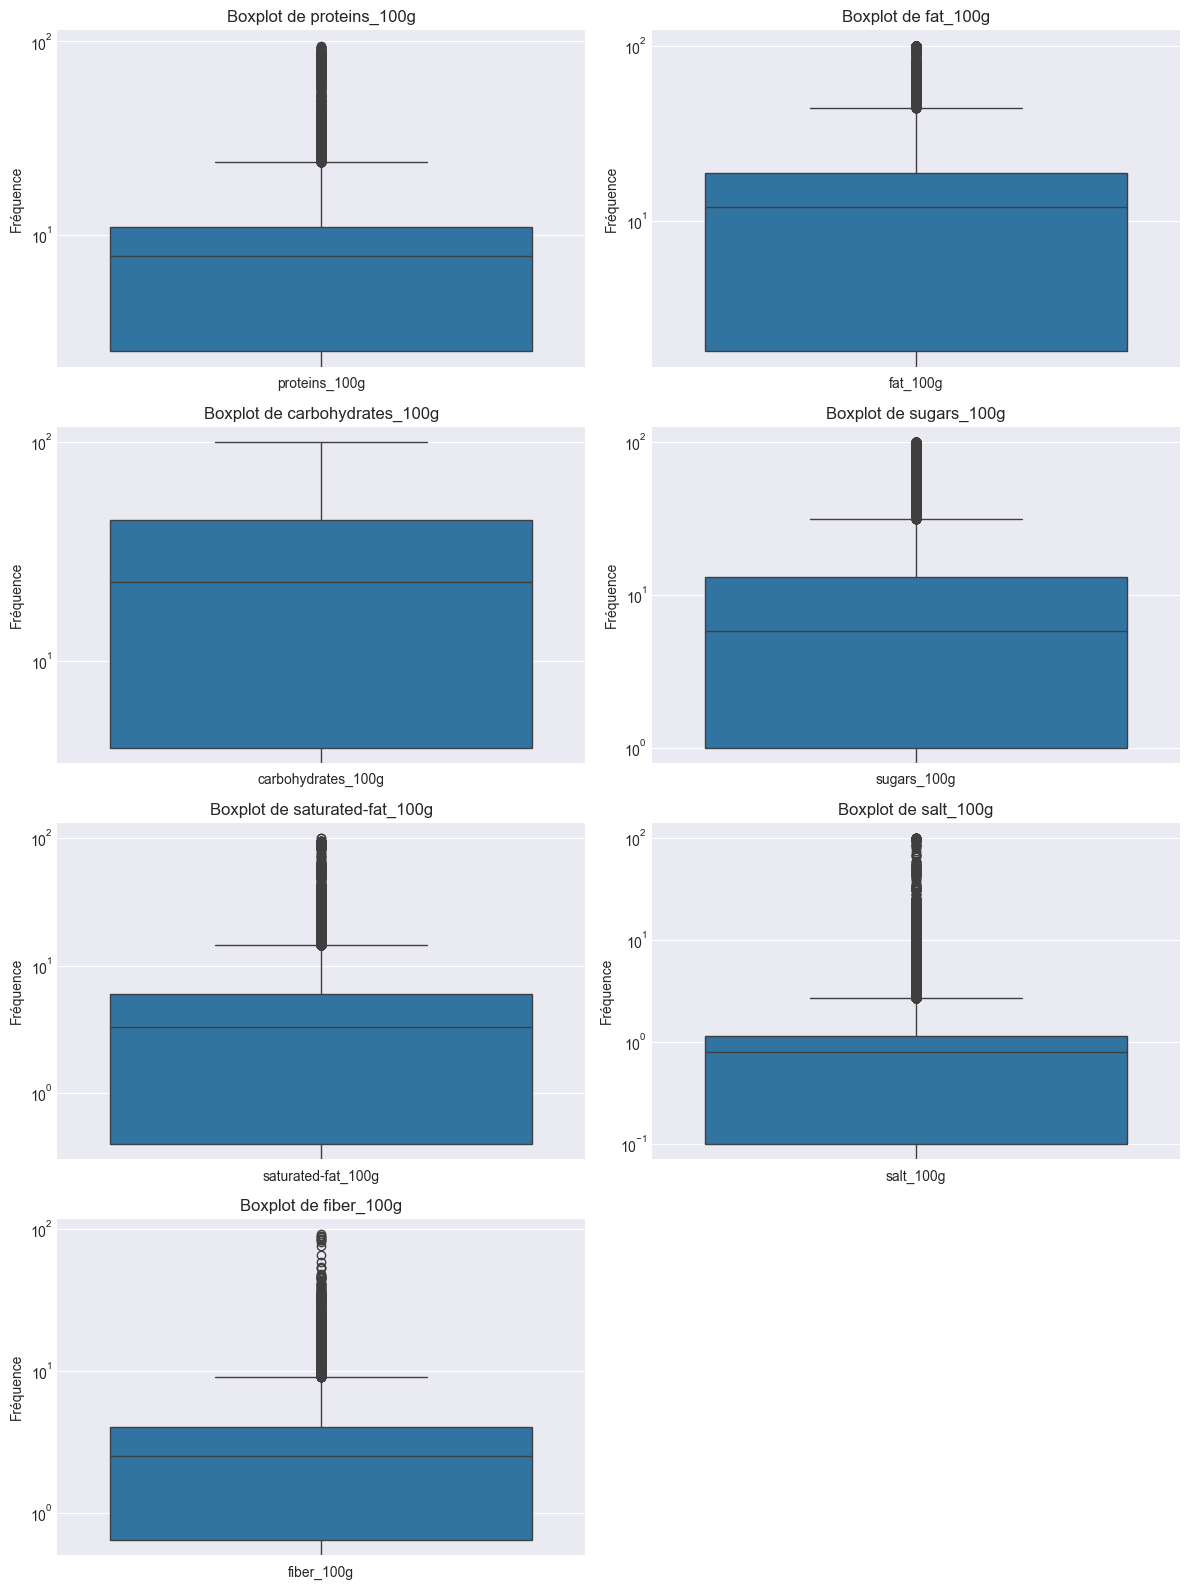

In [43]:
graphiques(df_cleaned, colonnes_suspectes, plot_type="boxplot", log=True)
graphiques(df_cleaned, colonnes_suspectes, plot_type="boxplot", log=True)

Les valeurs ont bien été imputées et n'impactent pas la distribution, ce qui signifie que nous pouvons continuer!

# 4 : Analyses univariée et bivariée

## 1. Analyse Univariée

On analyse tout d'abord les variables nutritionnelles.

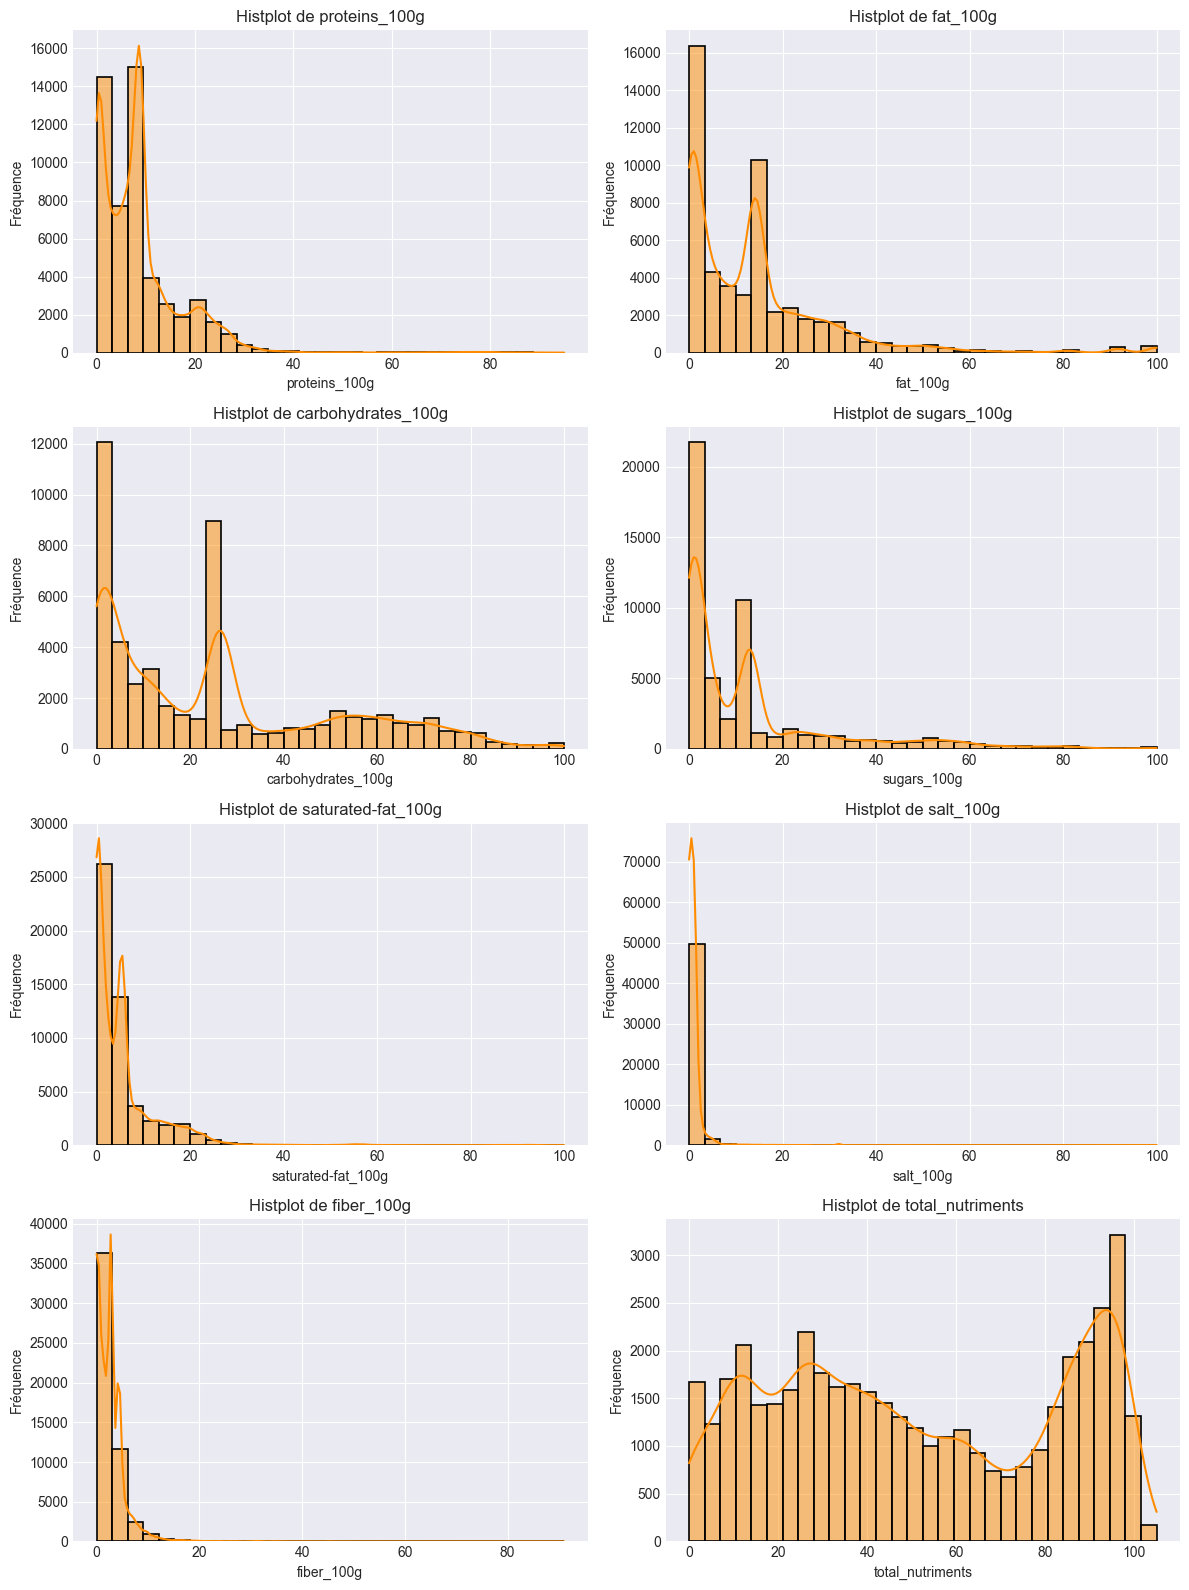

In [44]:
colonnes_nutriments = colonnes_suspectes + ["total_nutriments"]
graphiques(df_cleaned, colonnes_nutriments, plot_type="histplot")

Les points à retenir :
- Les distributions sont souvent asymétriques, avec une majorité de produits ayant des valeurs faibles et quelques produits avec des valeurs très élevées (effet des outliers naturels).
- Le sucre (sugars_100g) et le sel (salt_100g) ont des pics à zéro, ce qui est logique car de nombreux produits n’en contiennent pas.
- Les lipides (fat_100g) et les glucides (carbohydrates_100g) sont très variés, ce qui reflète la diversité des types d’aliments.


Maintenant, on va regarder les distributions des variables catégorielles :

In [45]:
nutriscore_palette = {
    'a': '#3D9970',  # Vert foncé
    'b': '#2ECC40',  # Vert clair
    'c': '#FFDC00',  # Jaune
    'd': '#FF851B',  # Orange
    'e': '#FF4136'   # Rouge
}

In [46]:
# Filtrer les valeurs non désirées
df_filtered = df_cleaned[df_cleaned["nutriscore_grade"].isin(['a', 'b', 'c', 'd', 'e'])]

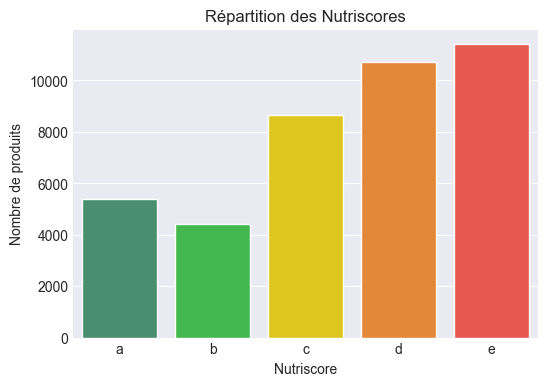

In [47]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df_filtered["nutriscore_grade"], order=['a', 'b', 'c', 'd', 'e'],
              palette=nutriscore_palette, hue=df_filtered["nutriscore_grade"], legend=False)
plt.title('Répartition des Nutriscores')
plt.xlabel('Nutriscore')
plt.ylabel('Nombre de produits')
plt.show()

Observation :
- Il y a plus de produits classés D et E que de produits A ou B.
- Cela indique que la base de données contient majoritairement des produits de qualité nutritionnelle moyenne à faible.

Cela peut influencer les analyses bivariées : il y aura plus de produits riches en graisses, sucres et sel.
On pourra observer si certaines catégories d’aliments sont plus souvent classées en D et E.

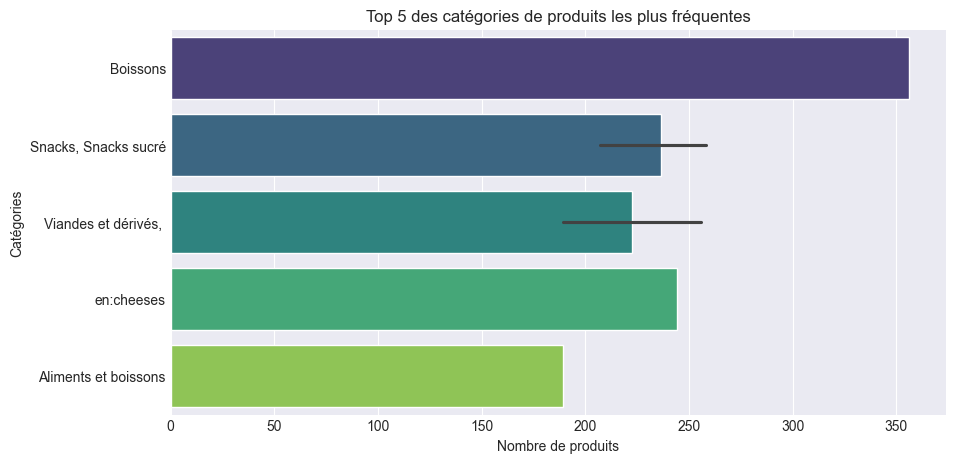

In [48]:
top_categories = df_cleaned["categories"].value_counts().head(8)
# Tronquer les noms de catégories
top_categories.index = top_categories.index.str[:20]

plt.figure(figsize=(10, 5))
sns.barplot(x=top_categories.values, y=top_categories.index, hue=top_categories.index, palette="viridis", legend=False)
plt.title("Top 5 des catégories de produits les plus fréquentes")
plt.xlabel("Nombre de produits")
plt.ylabel("Catégories")
plt.show()

# Abréger les noms trop longs

Observations :
- Les boissons sont la catégorie la plus représentée dans la base.
- Les snacks sucrés et confiseries apparaissent aussi très fréquemment.
- Les viandes, charcuteries et fromages sont bien présents, ce qui peut influencer les valeurs nutritionnelles globales.
- Les produits transformés et industriels dominent la base de données, ce qui pourrait expliquer la prédominance des Nutri-Scores D et E.

Certaines catégories alimentaires sont plus susceptibles d’être malsaines, et il pourrait être intéressant de les lier au Nutri-Score.

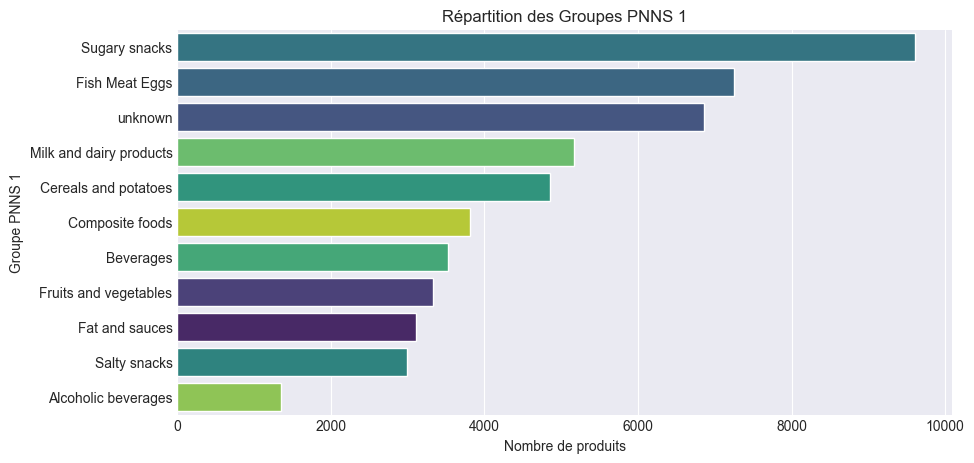

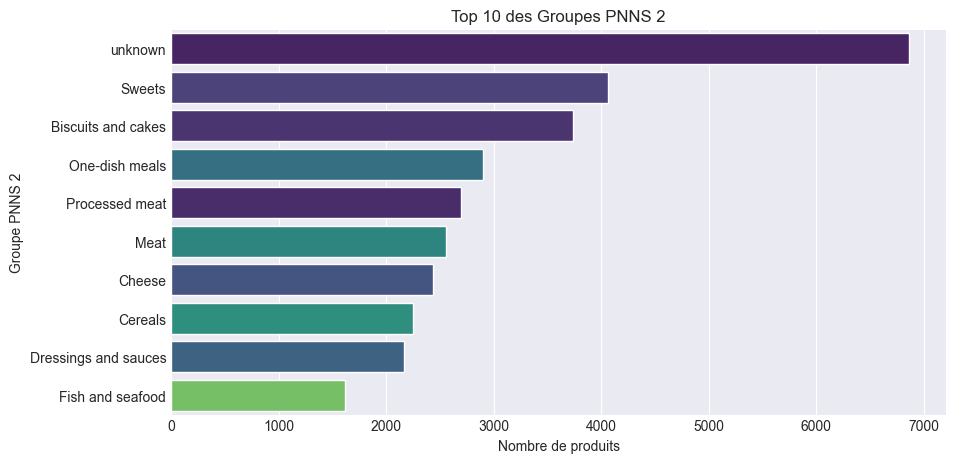

In [49]:
# Top groupes PNNS 1 (grandes catégories alimentaires)
plt.figure(figsize=(10, 5))
sns.countplot(y=df_cleaned["pnns_groups_1"], hue=df_cleaned['pnns_groups_1'], palette='viridis', legend=False, order=df_cleaned["pnns_groups_1"].value_counts().index)
plt.title("Répartition des Groupes PNNS 1")
plt.xlabel("Nombre de produits")
plt.ylabel("Groupe PNNS 1")
plt.show()

# Top groupes PNNS 2 (sous-catégories alimentaires)
plt.figure(figsize=(10, 5))
sns.countplot(y=df_cleaned["pnns_groups_2"], hue=df_cleaned['pnns_groups_2'], palette='viridis', legend=False, order=df_cleaned["pnns_groups_2"].value_counts().index[:10])
plt.title("Top 10 des Groupes PNNS 2")
plt.xlabel("Nombre de produits")
plt.ylabel("Groupe PNNS 2")
plt.show()

Observations :
- Comme vu précédemment, les snacks sucrés dominent la base, suivis par les viandes/œufs et les produits laitiers.
- On retrouve aussi les céréales et pommes de terre, les plats préparés, et les boissons.
- Beaucoup de produits transformés, ce qui peut expliquer la forte proportion de Nutri-Scores D et E.

Cela permet de comprendre quels types d’aliments influencent les tendances nutritionnelles.

## 2. Analyse Bivariée

On commence tout d'abord avec la matrice de corrélation, puis on enchainera avec des scatterplot pour un rendu plus visuel.

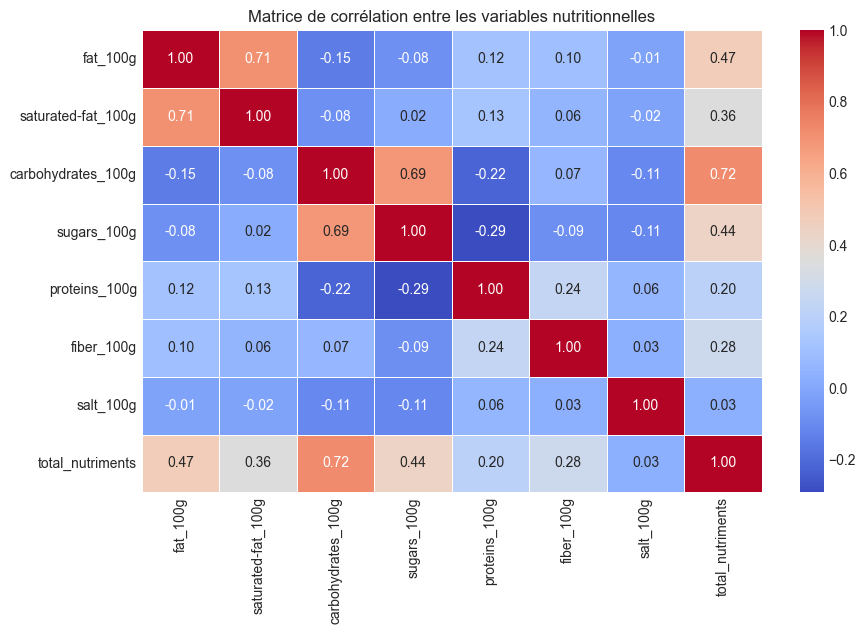

In [50]:
plt.figure(figsize=(10, 6))
corr_matrix = df_cleaned.select_dtypes(include=["number"]).corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matrice de corrélation entre les variables nutritionnelles")
plt.show()

Observations :

- **Corrélations fortes :**
  - `fat_100g` et `saturated-fat_100g` (0.71) → Logique, les acides gras saturés font partie des lipides totaux.
  - `carbohydrates_100g` et `sugars_100g` (0.69) → Le sucre fait partie des glucides.
  - `carbohydrates_100g` et `total_nutriments` (0.71) → Plus un produit est riche en glucides, plus il contribue à la densité nutritionnelle.

- **Corrélations faibles :**
  - `salt_100g` est presque indépendant des autres nutriments.
  - `fiber_100g` a des corrélations faibles avec le reste, sauf avec `proteins_100g` (0.25).


On passe aux scatterplots :

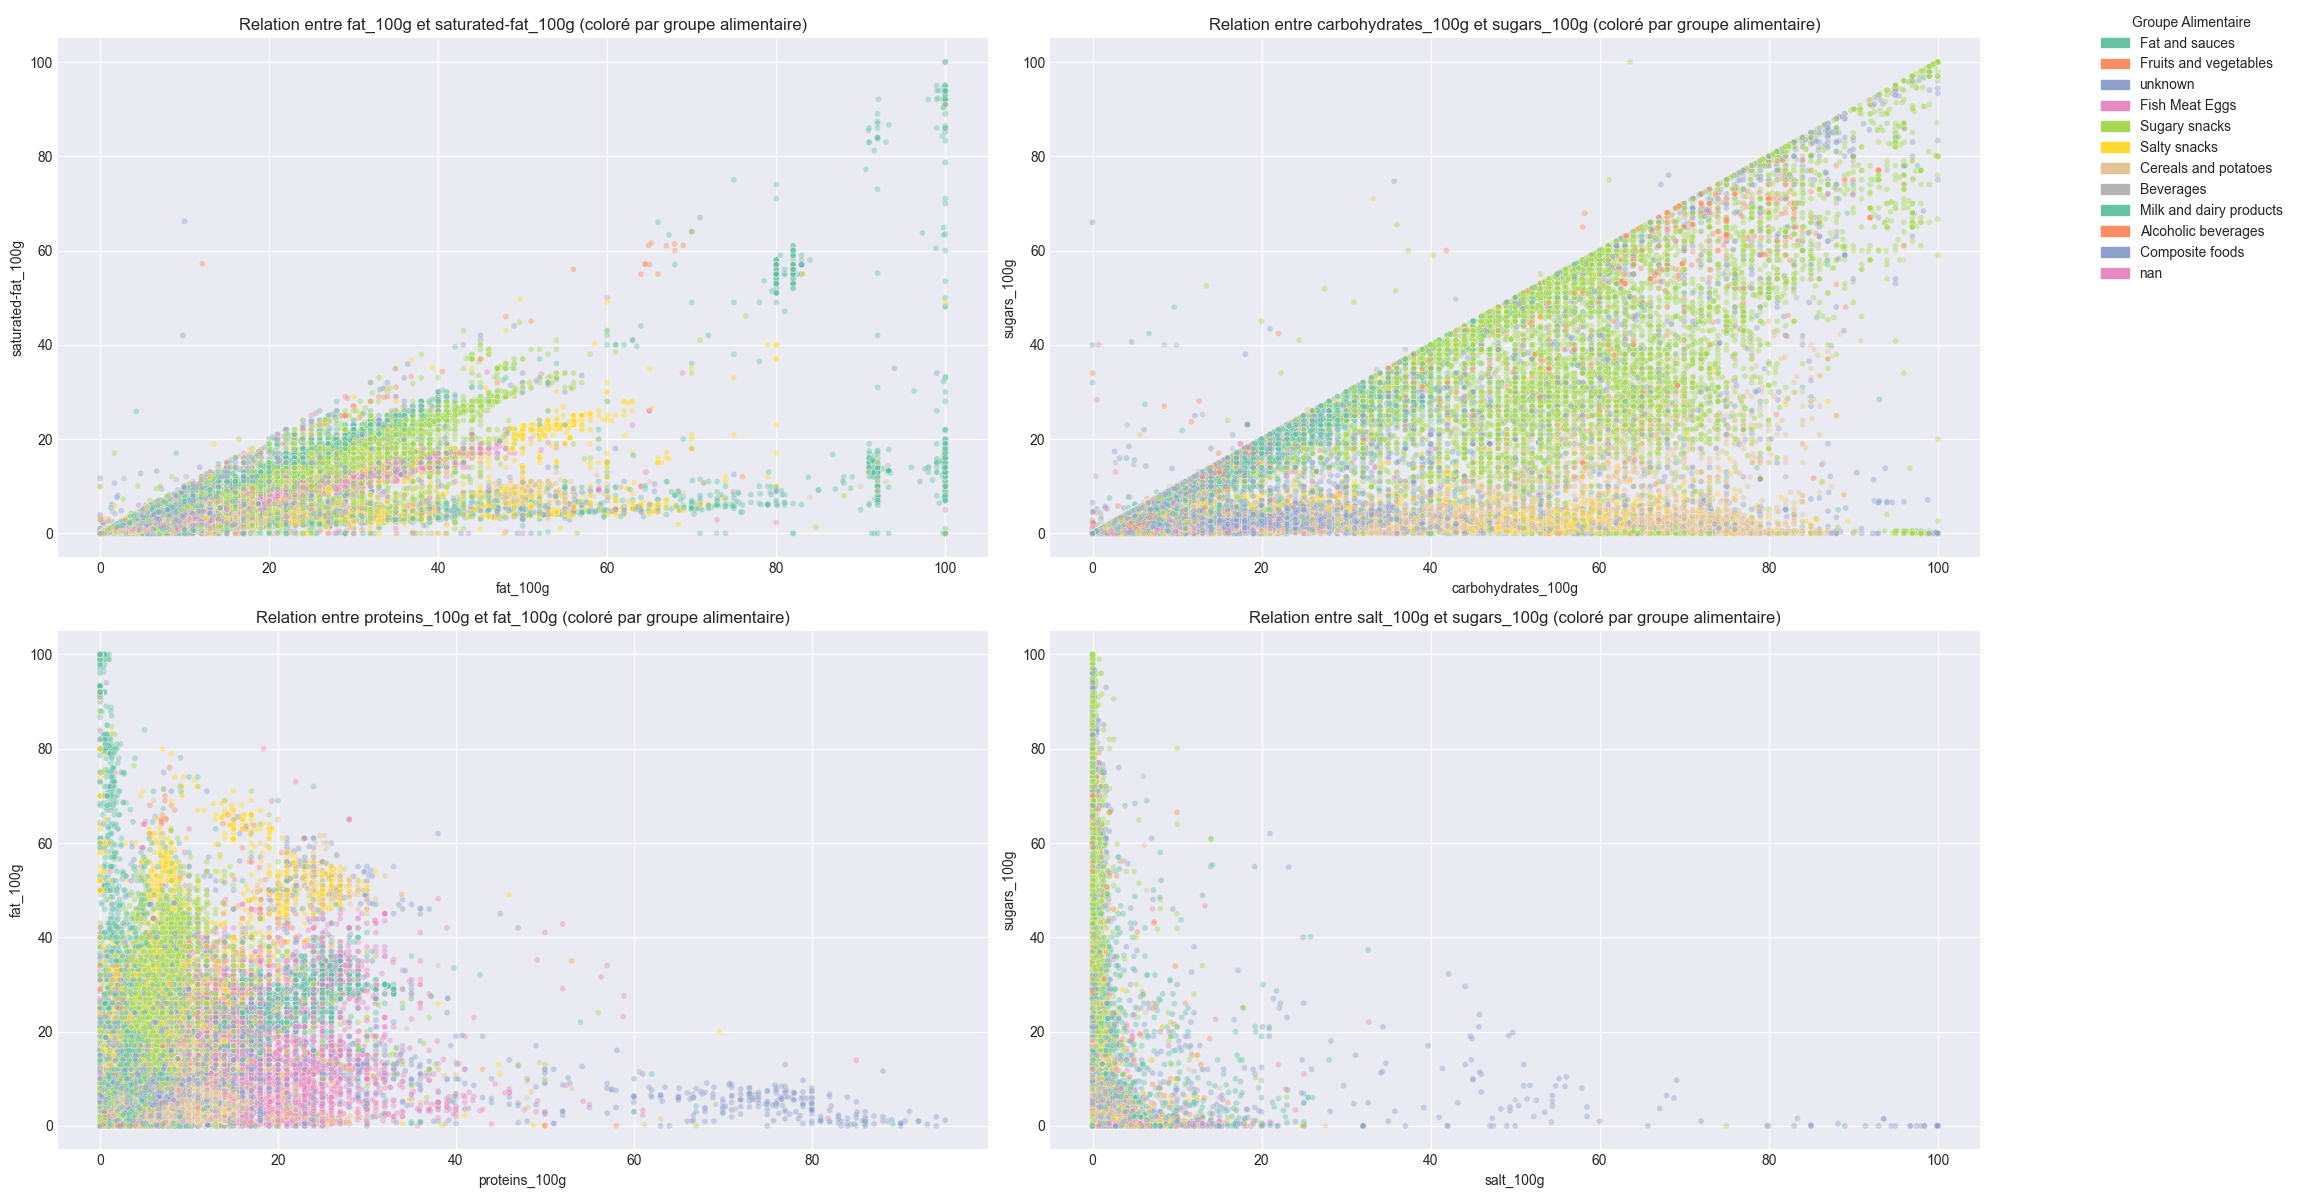

In [51]:
scatter_pairs = [
    ("fat_100g", "saturated-fat_100g"),
    ("carbohydrates_100g", "sugars_100g"),
    ("proteins_100g", "fat_100g"),
    ("salt_100g", "sugars_100g")
]

fig, axes = plt.subplots(2, 2, figsize=(20, 12))

for ax, (x_var, y_var) in zip(axes.flatten(), scatter_pairs):
    sns.scatterplot(
        data=df_cleaned, x=x_var, y=y_var, hue="pnns_groups_1",
        palette='Set2', alpha=0.4, s=20, ax=ax, legend=False
    )
    ax.set_title(f"Relation entre {x_var} et {y_var} (coloré par groupe alimentaire)")
    ax.set_xlabel(x_var)
    ax.set_ylabel(y_var)

unique_groups = df_cleaned["pnns_groups_1"].unique()
palette = sns.color_palette('Set2', len(unique_groups))
handles = [mpatches.Patch(color=palette[i], label=group) for i, group in enumerate(unique_groups)]

fig.legend(
    handles=handles,
    title="Groupe Alimentaire",
    loc="upper right",
    bbox_to_anchor=(1.15, 1)
)

plt.tight_layout()

plt.show()

Observations :

- **Relation `fat_100g` et `saturated-fat_100g`**
  - Corrélation attendue, les acides gras saturés font partie des lipides.
  - Les produits riches en lipides sont souvent riches en acides gras saturés.
  - Les produits riches en graisses saturées sont majoritairement dans les groupes "Fat and sauces" et "Milk and dairy products".

- **Relation `carbohydrates_100g` et `sugars_100g`**
  - Corrélation très forte, ce qui est logique : le sucre est un type de glucide.
  - Certains produits sont riches en glucides mais contiennent peu de sucre ajouté (ex. céréales complètes).
  - Les "Sugary snacks" et "Beverages" sont les plus riches en sucres, confirmant que ces produits sont principalement sucrés.

- **Relation `proteins_100g` et `fat_100g`**
  - Faible corrélation, mais on observe des produits riches en protéines et faibles en graisses (viandes maigres).

- **Relation `salt_100g` et `sugars_100g`**
  - Aucune corrélation claire, ces deux variables semblent indépendantes.
  - On observe deux tendances distinctes : certains produits riches en sel (snacks salés, plats préparés) mais la majorité est riche en sucre (confiseries, boissons).


## 3. Stats descriptives

In [52]:
nutriments = df_cleaned.select_dtypes(include=["number"])
nutriments.describe()

fat_100g  saturated-fat_100g  carbohydrates_100g   sugars_100g  \
count  51995.000000        51995.000000        51995.000000  51995.000000   
mean      14.166128            5.376094           26.343689     13.146949   
std       16.438786            7.428260           25.079036     17.891574   
min        0.000000            0.000000            0.000000      0.000000   
25%        1.800000            0.400000            4.000000      1.000000   
50%       12.000000            3.300000           23.000000      5.800000   
75%       18.740000            6.000000           44.000000     13.132152   
max      100.000000          100.000000          100.000000    100.000000   

       proteins_100g    fiber_100g     salt_100g  total_nutriments  
count   51995.000000  51995.000000  51995.000000      43776.000000  
mean        8.714399      2.745727      1.181083         51.174623  
std         8.755272      3.255353      3.727279         31.681752  
min         0.000000      0.000000      0.000000          0.000000  
25%         2.500000      0.640000      0.100000         24.180000  
50%         7.800000      2.500000      0.790000         46.800000  
75%        11.000000      4.000000      1.139458         84.322500  
max        95.000000     91.000000    100.000000        105.000000

#### Analyse Statistique Descriptive des Nutriments

Cette section présente une analyse descriptive des principaux nutriments présents dans les produits alimentaires de la base de données. Les statistiques clés permettent d’identifier les tendances générales ainsi que la variabilité entre les produits.

##### 1. Lipides (`fat_100g`)
- **Moyenne :** 14.17 g/100g
- **Écart-type :** 16.43 g → Indique une forte variabilité entre les produits riches en matières grasses et ceux plus maigres.
- **25% des produits contiennent moins de 1.8 g de lipides**, révélant une proportion significative d’aliments à faible teneur en graisses.

##### 2. Acides Gras Saturés (`saturated-fat_100g`)
- **Moyenne :** 5.36 g/100g
- **Écart-type :** 7.43 g → Variabilité importante, certains produits étant particulièrement riches en acides gras saturés.
- **Minimum :** 0 g → Certains aliments ne contiennent aucune trace d’acides gras saturés.

##### 3. Glucides (`carbohydrates_100g`)
- **Moyenne :** 26.44 g/100g
- **Écart-type :** 25.02 g → Différences marquées entre les produits très glucidiques et ceux pauvres en glucides.
- **25% des produits contiennent moins de 4.1 g de glucides**, tandis que certains dépassent 80 g/100g.

##### 4. Sucres (`sugars_100g`)
- **Moyenne :** 13.14 g/100g
- **Écart-type :** 17.88 g → Indique la présence de produits extrêmement sucrés ainsi que d’aliments sans sucre ajouté.
- **75% des produits contiennent moins de 20 g de sucre**, mais certains atteignent plus de **80 g/100g**.
- **La base de données contient une proportion nettement plus importante de produits sucrés que salés**, une observation confirmée par les visualisations (scatter plots).

##### 5. Protéines (`proteins_100g`)
- **Moyenne :** 8.7 g/100g
- **Écart-type :** 8.74 g → Grande diversité selon les sources de protéines (viandes, poissons vs snacks et boissons).
- **25% des produits affichent moins de 2.5 g de protéines**, ce qui révèle la présence de nombreux produits peu protéinés.

##### 6. Fibres (`fiber_100g`)
- **Moyenne :** 2.75 g/100g
- **Écart-type :** 3.26 g → Certains produits sont riches en fibres, tandis que d’autres en contiennent très peu, voire pas du tout.
- **50% des produits ont moins de 2 g de fibres**, soulignant une base de données où les aliments riches en fibres sont sous-représentés.

##### 7. Sel (`salt_100g`)
- **Moyenne :** 1.26 g/100g
- **Écart-type :** 4.53 g → Mise en évidence d’une forte hétérogénéité, certains produits affichant une teneur en sel très élevée.
- **25% des produits contiennent moins de 0.1 g de sel**, mais certains dépassent **40 g/100g**.
- **La base contient davantage de produits sucrés que salés**, une tendance confirmée par les analyses exploratoires.

---

##### Synthèse Globale
- **La base de données contient des produits très gras, sucrés et salés**, bien que la majorité affiche une composition plus modérée.
- **Les sucres montrent une distribution plus large que le sel**, indiquant une dominance des produits sucrés dans l’échantillon analysé.
- **Les teneurs en protéines et fibres sont relativement faibles**, ce qui peut refléter la forte présence de produits transformés.
- **L’écart-type élevé observé sur certains nutriments (lipides, sucres, sel) met en évidence une forte variabilité dans la composition des aliments.**

Ces observations corroborent les tendances identifiées dans les visualisations des données (scatter plots, histogrammes) et confirment la diversité nutritionnelle au sein de l’échantillon étudié.

## 4. Trouver des variables corrélées avec la cible

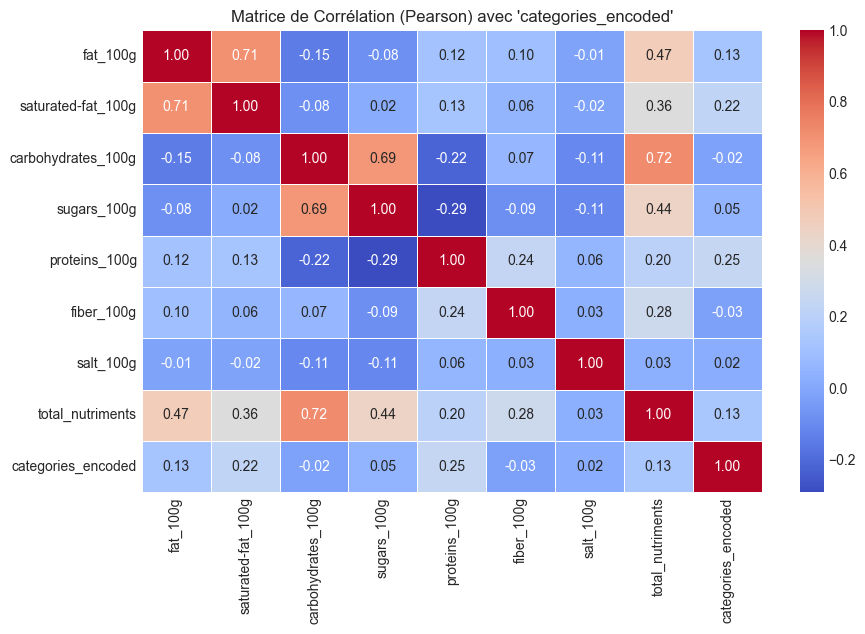

In [53]:
# S'assurer que 'categories_encoded' est bien présente
df_cleaned['categories_encoded'] = df_cleaned['categories'].astype('category').cat.codes

# Matrice de corrélation incluant categories_encoded
plt.figure(figsize=(10, 6))
sns.heatmap(df_cleaned.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matrice de Corrélation (Pearson) avec 'categories_encoded'")
plt.show()

In [54]:
# Calculer la corrélation de Pearson entre `categories_encoded` et les autres variables
pearson_corr = df_cleaned.corr(numeric_only=True, method="pearson")['categories_encoded'].drop('categories_encoded').sort_values(key=abs, ascending=False)
pearson_corr.head()

proteins_100g         0.247926
saturated-fat_100g    0.224733
total_nutriments      0.133892
fat_100g              0.126759
sugars_100g           0.047057
Name: categories_encoded, dtype: float64

#### Corrélations entre les Nutriments et `categories`

##### 1. Variables les plus corrélées avec `categories`
- **`proteins_100g` (0.247)** → La teneur en protéines joue un rôle important dans la distinction entre les catégories d’aliments.
- **`saturated-fat_100g` (0.224)** → Certaines catégories d’aliments, comme les produits laitiers, les snacks et les plats préparés, sont particulièrement riches en acides gras saturés.
- **`total_nutriments` (0.134)** → Cette variable reflète la densité nutritionnelle globale de certaines catégories.
- **`fat_100g` (0.126)** → Corrélation modérée, certaines catégories d’aliments étant plus riches en lipides que d’autres.
- **`sugars_100g` (0.048)** → Faible corrélation, le sucre étant présent dans un large éventail de catégories alimentaires.

##### 2. Interprétation
- **Les protéines et les graisses saturées sont les variables les plus discriminantes pour classifier les aliments.**
- **Les sucres sont répartis dans de nombreuses catégories, ce qui les rend moins pertinents comme critère de classification.**
- **Il est préférable d’éviter d’utiliser des variables fortement corrélées entre elles (ex. `fat_100g` et `saturated-fat_100g`).**

##### Conclusion
- **Ces résultats permettent d’identifier les variables les plus pertinentes** pour une future classification des aliments.
- **La corrélation de Pearson a mis en évidence les nutriments ayant le plus d’impact sur `categories`**, ce qui peut orienter les choix de modélisation.

# 5 : Analyse multi-variée

On va tout d'abord normaliser les données afin de pouvoir utiliser des méthodes statistiques plus poussées

In [55]:
robust_scaler = RobustScaler()
df_robust_scaled = df_cleaned.copy()
df_robust_scaled[colonnes_suspectes] = robust_scaler.fit_transform(df_robust_scaled[colonnes_suspectes])

## 1. ACP

##### Pourquoi faire une ACP (Analyse en Composantes Principales) ?
L'ACP est utilisée ici pour **réduire la dimensionnalité** des variables nutritionnelles (sucre, sel, graisses, etc.) tout en conservant un maximum d'information. Cela permet d'identifier des **axes principaux expliquant la variance des produits alimentaires** et de mieux visualiser leur répartition en fonction des profils nutritionnels.


In [56]:
# Filtrer pour ne garder que les colonnes numériques et enlever celles qui sont trop corrélées
colonnes_acp = ['proteins_100g', 'sugars_100g', 'saturated-fat_100g', 'salt_100g', 'fiber_100g']

print("Colonnes numériques finales pour l'ACP :", colonnes_acp)

Colonnes numériques finales pour l'ACP : ['proteins_100g', 'sugars_100g', 'saturated-fat_100g', 'salt_100g', 'fiber_100g']


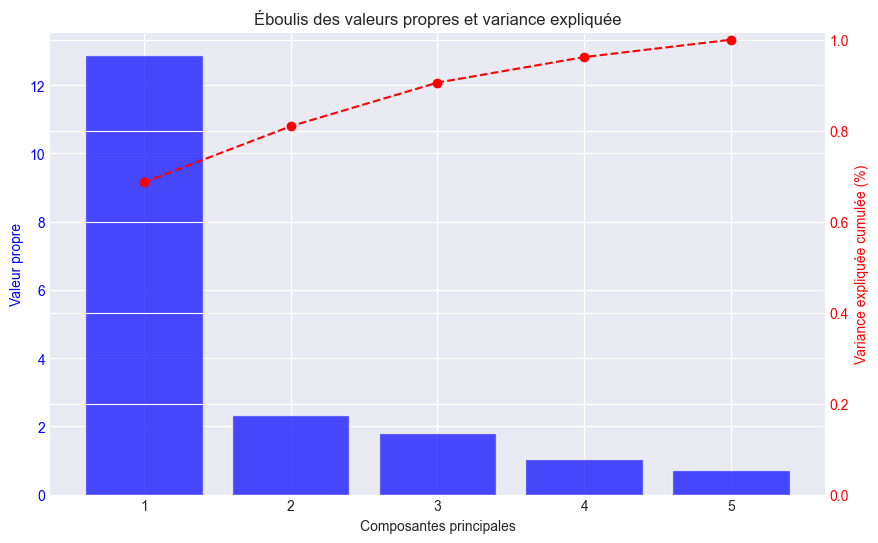

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Appliquer l'ACP
acp = PCA(n_components=df_robust_scaled[colonnes_acp].shape[1])
x_acp = acp.fit_transform(df_robust_scaled[colonnes_acp])

# Valeurs propres et variance expliquée
eigenvalues = acp.explained_variance_
explained_variance_ratio = acp.explained_variance_ratio_

# Création de la variance expliquée cumulée
cumulative_variance = np.cumsum(explained_variance_ratio)

# Création de la figure
fig, ax1 = plt.subplots(figsize=(10, 6))

# Histogramme des valeurs propres
ax1.bar(range(1, len(eigenvalues) + 1), eigenvalues, color='blue', alpha=0.7)
ax1.set_xlabel("Composantes principales")
ax1.set_ylabel("Valeur propre", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Axe secondaire pour la variance expliquée cumulée
ax2 = ax1.twinx()
ax2.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance,
         marker='o', linestyle='--', color='red')

ax2.set_ylabel("Variance expliquée cumulée (%)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# 🔥 Fixer l'échelle de l'axe secondaire de 0 à 1
ax2.set_ylim(0)

# Titres et affichage
plt.title("Éboulis des valeurs propres et variance expliquée")
plt.show()

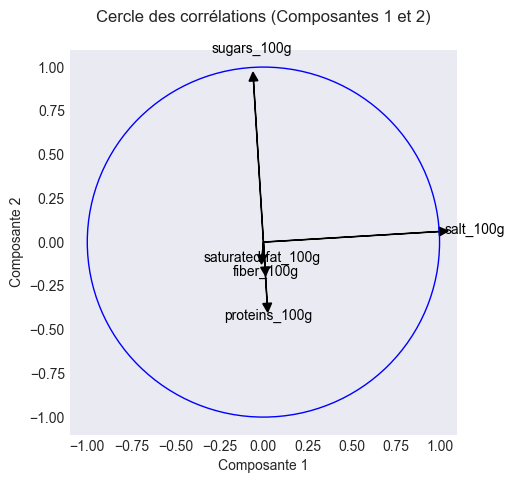

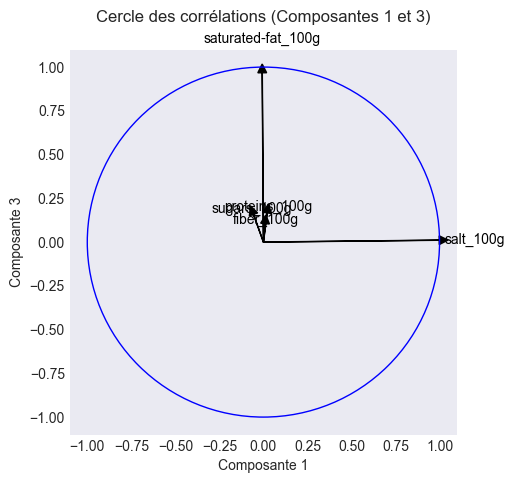

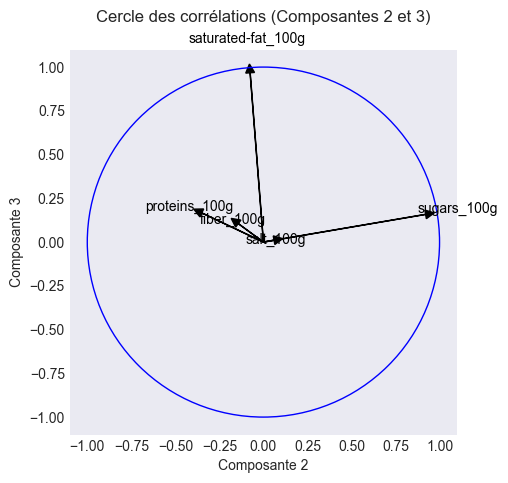

In [58]:
n_components = acp.n_components_  # Nombre de composantes principales

# Limiter aux 3 premières composantes
for axis1 in range(3):
    for axis2 in range(axis1 + 1, 3):
        cercle_correlations(acp, colonnes_acp, axis1, axis2)

#### Interprétation des cercles de corrélations

##### Cercle des corrélations (Composantes 1 et 2)
- **Salt_100g** est presque parfaitement aligné avec la Composante 1, ce qui signifie qu'il est fortement représenté sur cet axe.
- **Sugars_100g** est fortement projeté sur la Composante 2, ce qui veut dire que cette composante capte une part importante de la variance liée au sucre.
- **Saturated fat, fiber et proteins** sont proches les uns des autres, suggérant une corrélation entre ces variables.

**Interprétation :**
- La **Composante 1** semble représenter une opposition entre le sel et les autres nutriments.
- La **Composante 2** capte une dimension liée au sucre.

##### Cercle des corrélations (Composantes 1 et 3)
- **Salt_100g** reste dominant sur la Composante 1.
- **Saturated fat_100g** est fortement corrélé à la Composante 3.
- Les autres variables semblent moins bien représentées sur ce plan.

**Interprétation :**
- La **Composante 3** pourrait être une dimension liée aux matières grasses saturées, qui n’était pas captée dans le premier plan.

##### Cercle des corrélations (Composantes 2 et 3)
- **Saturated fat_100g** est fortement projeté sur la Composante 3.
- **Sugars_100g** est bien représenté sur la Composante 2.
- **Salt_100g, fiber_100g et proteins_100g** sont proches du centre, indiquant qu'ils ne sont pas bien expliqués par ce plan.

**Interprétation :**
- Ce plan montre que sugars et saturated fat sont des dimensions indépendantes, captées par les axes 2 et 3.
- Salt est mal représenté ici, ce qui confirme que la composante 1 est plus pertinente pour le décrire.

##### Conclusion générale
- **Composante 1** : Principalement influencée par le sel.
- **Composante 2** : Capture l’information sur le sucre.
- **Composante 3** : Explique surtout la présence de matières grasses saturées.

Ces interprétations permettent de comprendre comment les variables initiales influencent les composantes principales et quelles dimensions elles représentent.


In [59]:
# Variance expliquée par chaque composante
print("Variance expliquée par chaque composante :", acp.explained_variance_ratio_)

Variance expliquée par chaque composante : [0.68634823 0.12345249 0.09587394 0.05617717 0.03814816]


On a donc 3 composantes qui nous permettent d'expliquer plus de 90% de la variance.

In [60]:
composantes_acp = pd.DataFrame(acp.components_, columns=df_robust_scaled[colonnes_acp].columns, index=[f'PC{i+1}' for i in range(x_acp.shape[1])])
composantes_acp.head()

proteins_100g  sugars_100g  saturated-fat_100g  salt_100g  fiber_100g
PC1       0.021334    -0.056356           -0.006693   0.998117    0.009347
PC2      -0.349909     0.920793           -0.075420   0.060300   -0.142757
PC3       0.166657     0.158227            0.967433   0.010870    0.105573
PC4       0.575338     0.311830           -0.228728  -0.002973    0.720710
PC5       0.719945     0.163372           -0.077619  -0.000410   -0.670048

Cela confirme bien nos cercles de corrélations :
- La première composante correspondrait au sel
- La deuxième composante correspondrait au sucre
- La troisième composante correspondrait à la graisse saturée

Visualisations :

In [61]:
# Récupérer les coordonnées des composantes principales
pc1 = x_acp[:, 0]  # PC1
pc2 = x_acp[:, 1]  # PC2
pc3 = x_acp[:, 2]

# Convertir en DataFrame pour manipuler plus facilement
df_pca = pd.DataFrame({'PC1': pc1, 'PC2': pc2, 'PC3': pc3,'product_name': df_cleaned['product_name']})

# Transformation logarithmique de PC1
pc1_min = df_pca["PC1"].min()
if pc1_min < 0:
    df_pca["PC1_log"] = np.log1p(df_pca["PC1"] - pc1_min + 1)  # Décalage vers 0
else:
    df_pca["PC1_log"] = np.log1p(df_pca["PC1"])

# Sélection des valeurs extrêmes
top_pc1 = df_pca.nlargest(1, 'PC1')
top_pc2 = df_pca.nlargest(1, 'PC2')
top_pc3 = df_pca.nlargest(1, 'PC3')

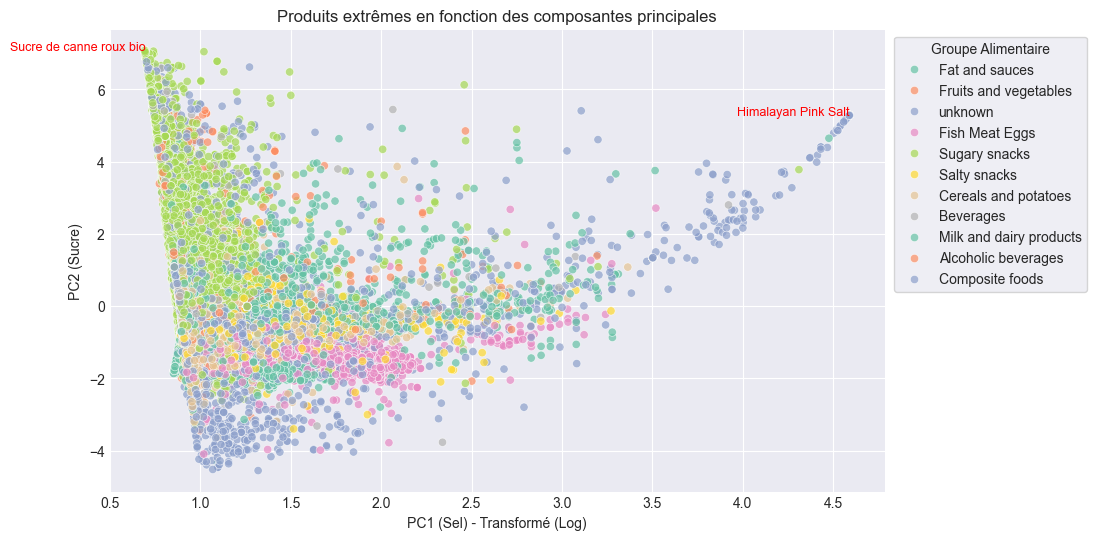

In [62]:
# PC1 & PC2
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pca["PC1_log"], y=df_pca["PC2"], alpha=0.7, hue=df_robust_scaled["pnns_groups_1"], palette='Set2')

for _, row in pd.concat([top_pc1, top_pc2]).iterrows():
    pc1_log_value = np.log1p(row["PC1"] - pc1_min + 1) if pc1_min < 0 else np.log1p(row["PC1"])
    plt.text(pc1_log_value, row["PC2"], row["product_name"], fontsize=9, ha='right', color='red')

plt.xlabel('PC1 (Sel) - Transformé (Log)')
plt.ylabel('PC2 (Sucre)')
plt.title('Produits extrêmes en fonction des composantes principales')
plt.legend(title="Groupe Alimentaire", loc="upper right", bbox_to_anchor=(1.27, 1), frameon=True)
plt.grid(True)
plt.show()

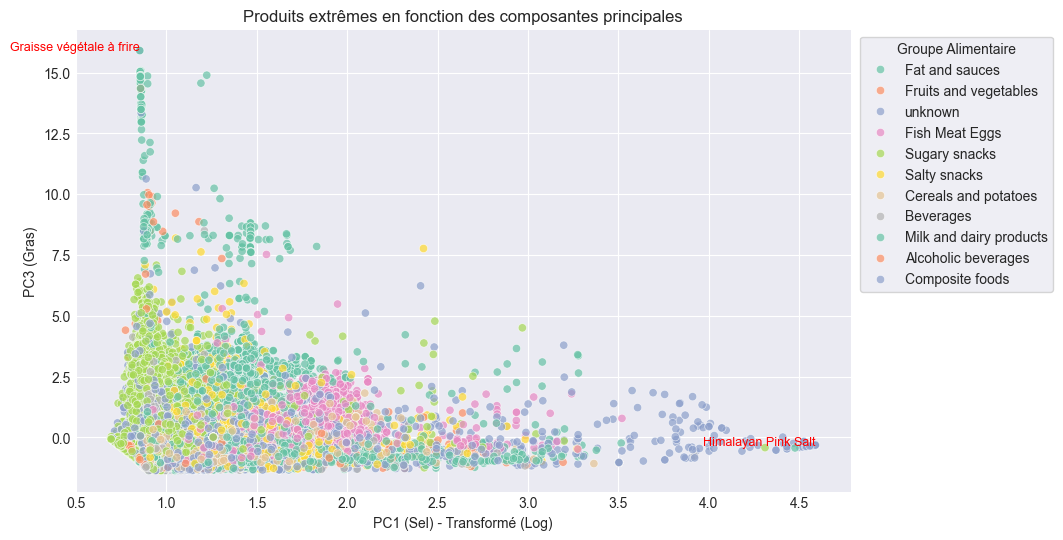

In [63]:
# PC1 & PC3
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pca["PC1_log"], y=df_pca["PC3"], alpha=0.7, hue=df_robust_scaled["pnns_groups_1"], palette='Set2')

for _, row in pd.concat([top_pc1, top_pc3]).iterrows():
    pc1_log_value = np.log1p(row["PC1"] - pc1_min + 1) if pc1_min < 0 else np.log1p(row["PC1"])
    plt.text(pc1_log_value, row["PC3"], row["product_name"], fontsize=9, ha='right', color='red')

plt.xlabel('PC1 (Sel) - Transformé (Log)')
plt.ylabel('PC3 (Gras)')
plt.title('Produits extrêmes en fonction des composantes principales')
plt.legend(title="Groupe Alimentaire", loc="upper right", bbox_to_anchor=(1.27, 1), frameon=True)
plt.grid(True)
plt.show()

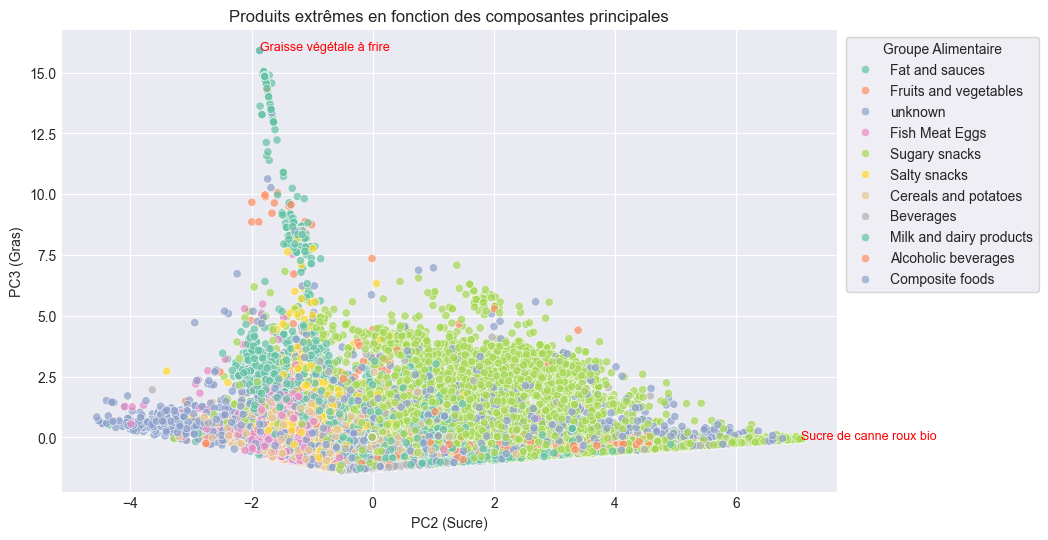

In [64]:
# PC2 & PC3
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pca["PC2"], y=df_pca["PC3"], alpha=0.7, hue=df_robust_scaled["pnns_groups_1"], palette='Set2')

for _, row in pd.concat([top_pc2, top_pc3]).iterrows():
    plt.text(row["PC2"], row["PC3"], row["product_name"], fontsize=9, ha='left', color='red')

plt.xlabel('PC2 (Sucre)')
plt.ylabel('PC3 (Gras)')
plt.title('Produits extrêmes en fonction des composantes principales')
plt.legend(title="Groupe Alimentaire", loc="upper right", bbox_to_anchor=(1.27, 1), frameon=True)
plt.grid(True)
plt.show()

Observations :

- PC1 (Sel) vs PC2 (Sucre)
Produit le plus salé : "Himalayan Pink Salt" → Normal, c'est du sel pur.
Produit le plus sucré : "Sucre de canne roux bio" → Logique aussi, c'est du sucre pur.

- PC2 (Sucre) vs PC3 (Gras)
Produit très gras : "Graisse végétale à frire" → Encore une fois, ça a du sens, car c'est de la graisse pure.
Produit très sucré : "Sucre de canne roux bio" → Confirme bien que PC2 est bien un axe du sucre.

- PC1 (Sel) vs PC3 (Gras)
Les produits gras et salés semblent bien séparés.
"Himalayan Pink Salt" toujours extrême en sel et "Graisse végétale à frire" extrême en gras.

## 2. ANOVA

##### Pourquoi faire une ANOVA (Analyse de la Variance) ?
L'ANOVA est utilisée pour **comparer les moyennes de plusieurs groupes** et déterminer si une variable nutritionnelle (sucre, gras, sel…) varie de manière significative selon des catégories comme le **Nutri-Score ou les groupes alimentaires (PNNS)**. Elle permet de vérifier si certaines catégories ont des profils nutritionnels significativement différents.


📊 ANOVA pour sugars_100g


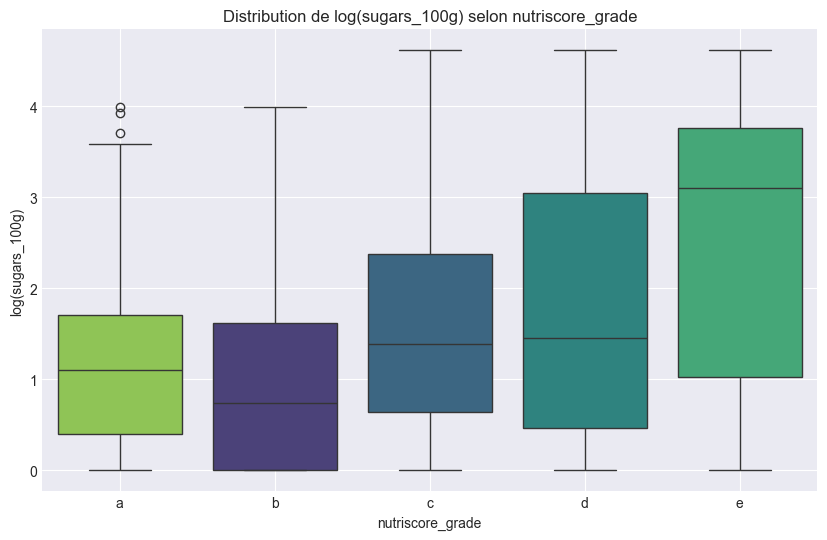

Statistique F : 2144.841
P-valeur : 0.00000
🔴 Il existe une différence significative entre les groupes pour log(sugars_100g).

📊 ANOVA pour saturated-fat_100g


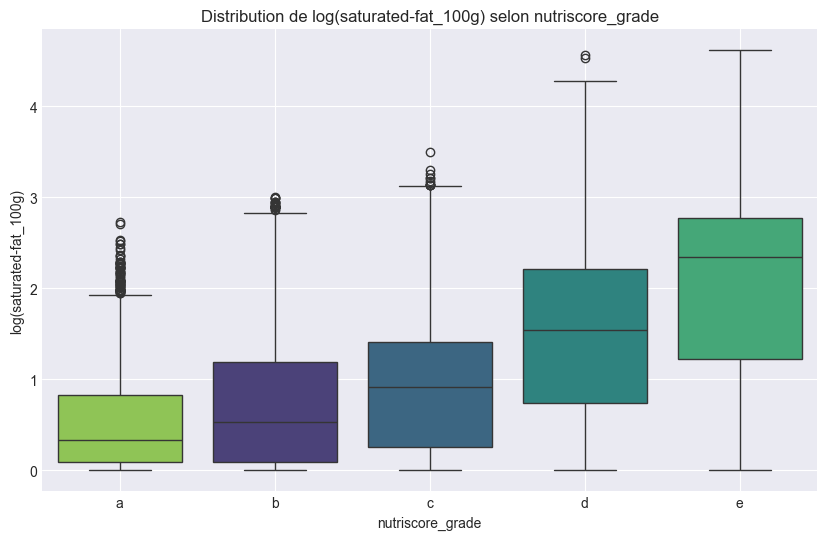

Statistique F : 3263.417
P-valeur : 0.00000
🔴 Il existe une différence significative entre les groupes pour log(saturated-fat_100g).

📊 ANOVA pour salt_100g


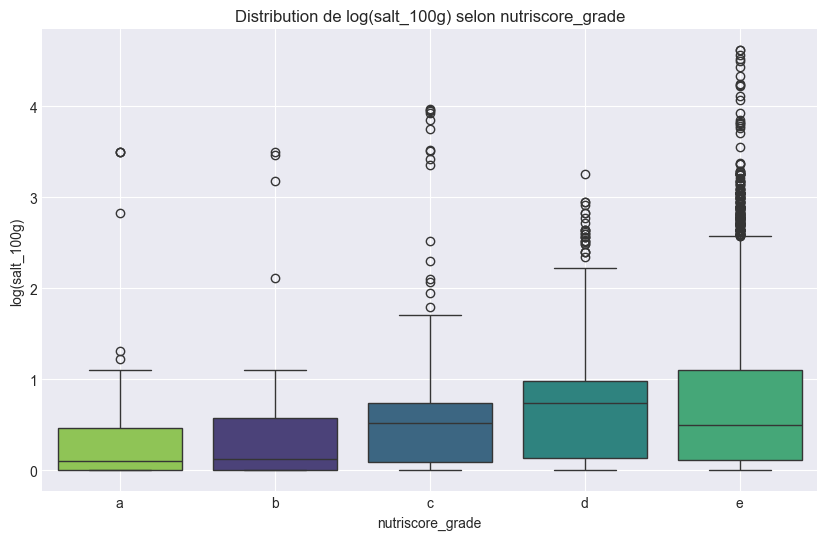

Statistique F : 1223.795
P-valeur : 0.00000
🔴 Il existe une différence significative entre les groupes pour log(salt_100g).

📊 ANOVA pour fiber_100g


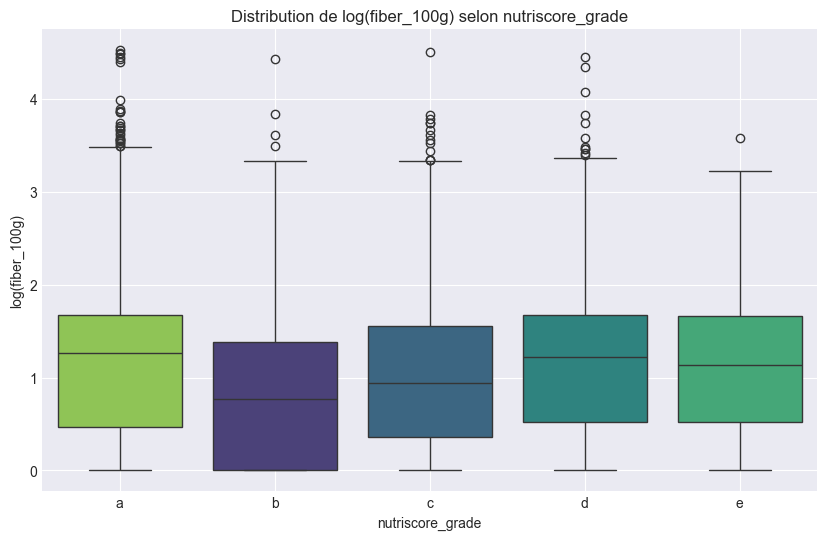

Statistique F : 218.048
P-valeur : 0.00000
🔴 Il existe une différence significative entre les groupes pour log(fiber_100g).


In [65]:
categorie = "nutriscore_grade"

# Filtrer les Nutri-Scores valides
df_cleaned_filtre = df_cleaned.loc[df_cleaned["nutriscore_grade"].isin(["a", "b", "c", "d", "e"])].copy()

for variable_numerique in ["sugars_100g", "saturated-fat_100g", "salt_100g", "fiber_100g"]:
    print(f"\n📊 ANOVA pour {variable_numerique}")

    # Appliquer une transformation logarithmique en utilisant .loc pour éviter l'avertissement
    df_cleaned_filtre.loc[:, f"log_{variable_numerique}"] = np.log1p(df_cleaned_filtre[variable_numerique])

    # 🟢 2. Vérifier les distributions après transformation logarithmique
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df_cleaned_filtre[categorie], y=df_cleaned_filtre[f"log_{variable_numerique}"], order=['a', 'b', 'c', 'd', 'e'], palette="viridis", hue=df_cleaned_filtre[categorie], legend=False)
    plt.title(f"Distribution de log({variable_numerique}) selon {categorie}")
    plt.xlabel(categorie)
    plt.ylabel(f"log({variable_numerique})")
    plt.grid(True)
    plt.show()

    # Préparer les groupes pour l'ANOVA
    groupes = [df_cleaned_filtre.loc[df_cleaned_filtre["nutriscore_grade"] == cat, f"log_{variable_numerique}"].dropna()
               for cat in ["a", "b", "c", "d", "e"]]

    # Réaliser l'ANOVA
    stat, p_value = stats.f_oneway(*groupes)

    print(f"Statistique F : {stat:.3f}")
    print(f"P-valeur : {p_value:.5f}")

    if p_value < 0.05:
        print(f"🔴 Il existe une différence significative entre les groupes pour log({variable_numerique}).")
    else:
        print(f"🟢 Aucune différence significative détectée pour log({variable_numerique}).")



📊 ANOVA pour sugars_100g


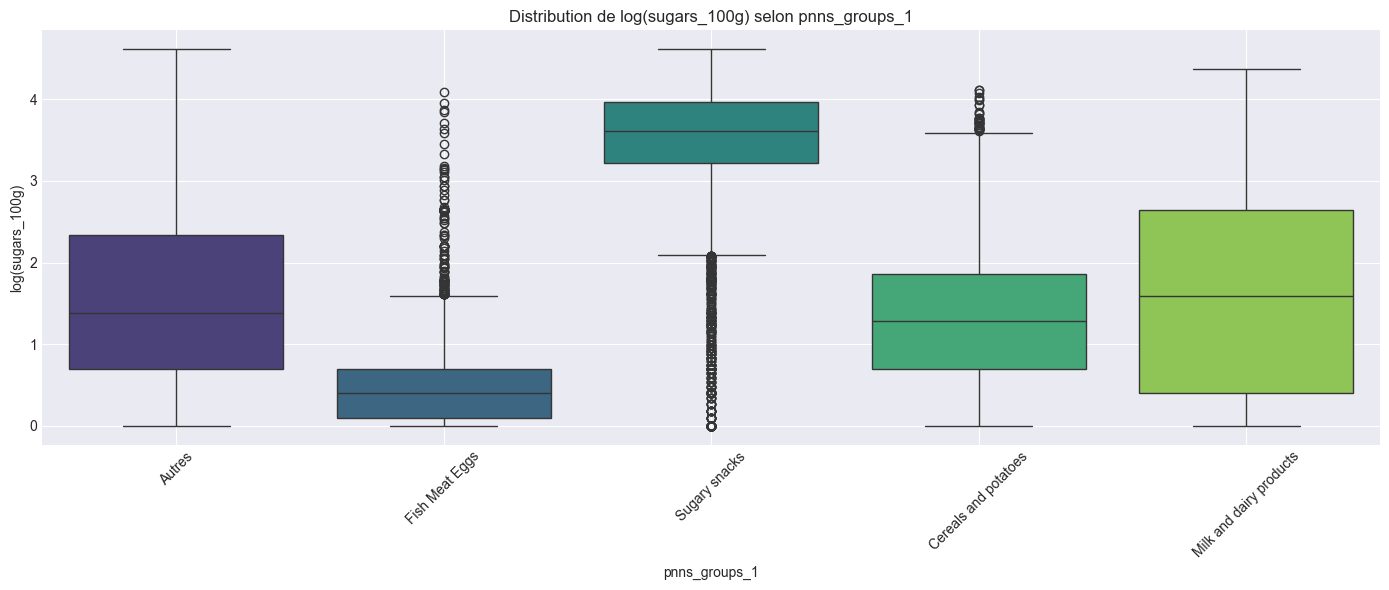

Statistique F : 9078.126
P-valeur : 0.00000
🔴 Il existe une différence significative entre les groupes pour log(sugars_100g).

📊 ANOVA pour saturated-fat_100g


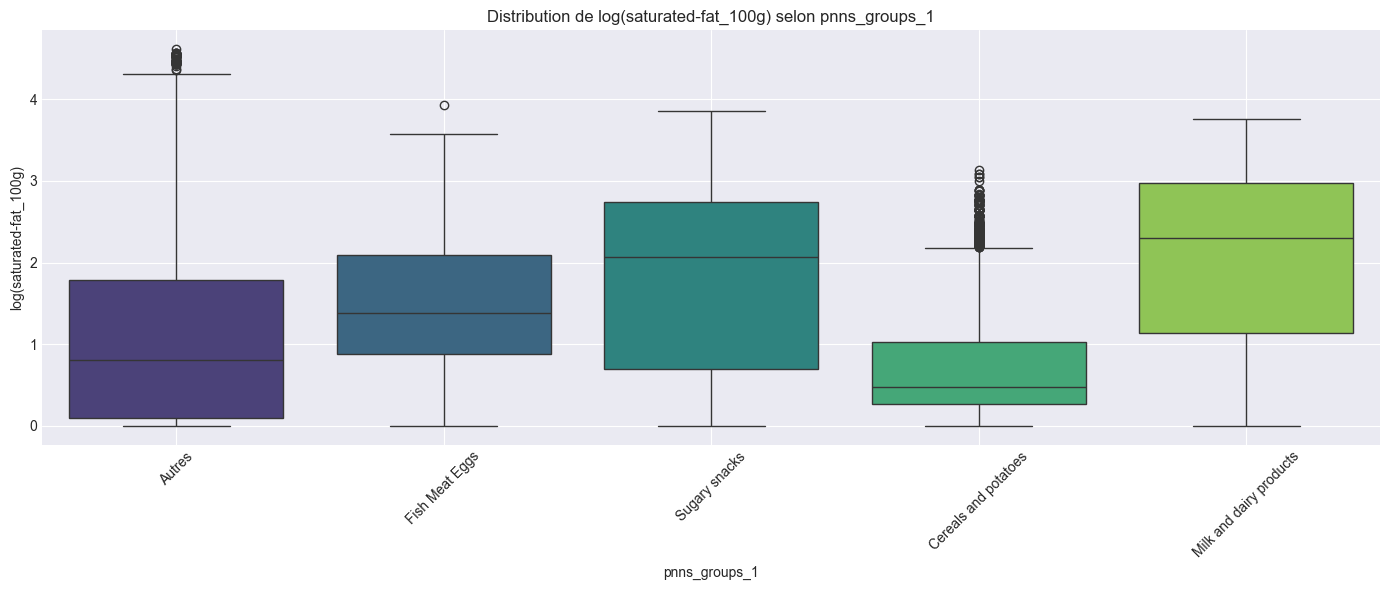

Statistique F : 1763.506
P-valeur : 0.00000
🔴 Il existe une différence significative entre les groupes pour log(saturated-fat_100g).

📊 ANOVA pour salt_100g


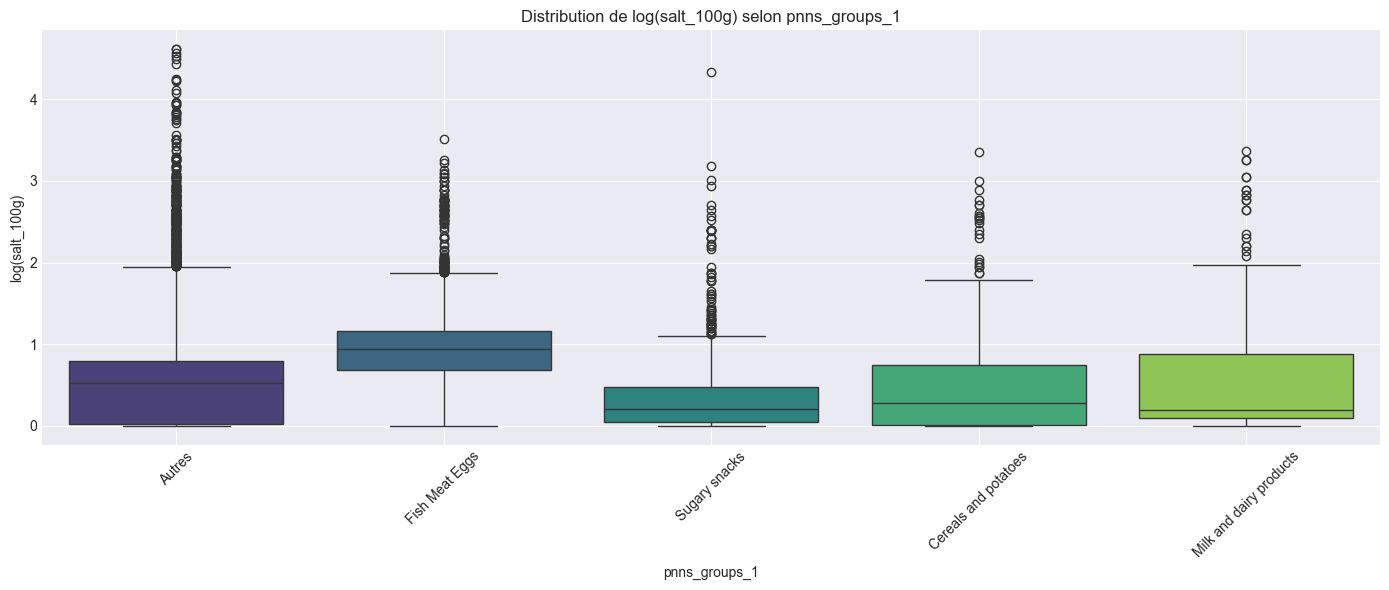

Statistique F : 1745.274
P-valeur : 0.00000
🔴 Il existe une différence significative entre les groupes pour log(salt_100g).

📊 ANOVA pour fiber_100g


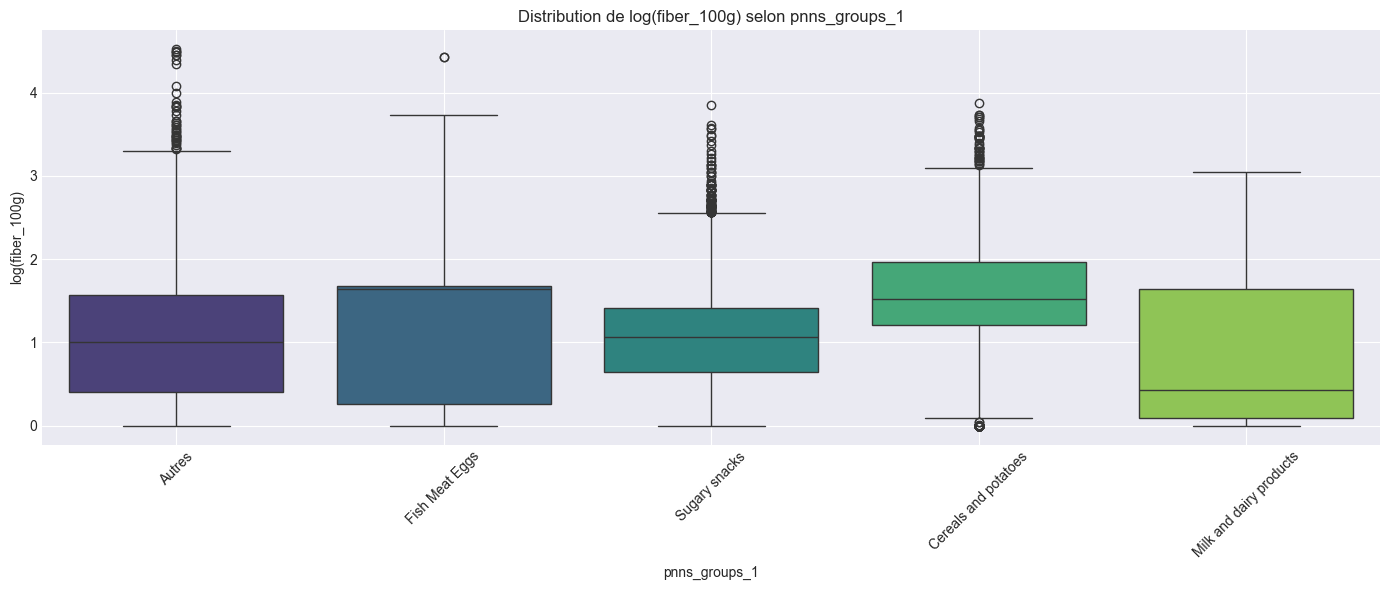

Statistique F : 786.324
P-valeur : 0.00000
🔴 Il existe une différence significative entre les groupes pour log(fiber_100g).


In [66]:
categorie = "pnns_groups_1"
variables_numeriques = ["sugars_100g", "saturated-fat_100g", "salt_100g", "fiber_100g"]

df_cleaned_filtre[categorie] = df_cleaned_filtre[categorie].replace('unknown', 'Autres')

# 1. Regrouper les catégories peu fréquentes
top_categories = df_cleaned_filtre[categorie].value_counts().nlargest(5).index  # Top 5 catégories
df_cleaned_filtre[categorie + "_regroupe"] = df_cleaned_filtre[categorie].where(
    df_cleaned_filtre[categorie].isin(top_categories), "Autres"
)

# 2. Appliquer une transformation logarithmique et réaliser l'ANOVA
for variable_numerique in variables_numeriques:
    print(f"\n📊 ANOVA pour {variable_numerique}")

    # Transformation logarithmique
    df_cleaned_filtre.loc[:, f"log_{variable_numerique}"] = np.log1p(df_cleaned_filtre[variable_numerique])

    # Boxplot avec regroupement des catégories
    plt.figure(figsize=(14, 6))  # Largeur augmentée à 14 pouces
    sns.boxplot(
        x=df_cleaned_filtre[categorie + "_regroupe"],
        y=df_cleaned_filtre[f"log_{variable_numerique}"],
        palette="viridis",
        hue=df_cleaned_filtre[categorie + "_regroupe"],
        legend=False
    )
    plt.title(f"Distribution de log({variable_numerique}) selon {categorie}")
    plt.xlabel(categorie)
    plt.ylabel(f"log({variable_numerique})")
    plt.xticks(rotation=45)  # Rotation des étiquettes de 45 degrés
    plt.grid(True)
    plt.tight_layout()  # Ajuster la mise en page pour éviter les chevauchements
    plt.show()

    # Réaliser l'ANOVA sur les groupes regroupés
    groupes = [
        df_cleaned_filtre[df_cleaned_filtre[categorie + "_regroupe"] == groupe][f"log_{variable_numerique}"]
        for groupe in df_cleaned_filtre[categorie + "_regroupe"].unique()
    ]
    stat, p_value = stats.f_oneway(*groupes)
    print(f"Statistique F : {stat:.3f}")
    print(f"P-valeur : {p_value:.5f}")

    if p_value < 0.05:
        print(f"🔴 Il existe une différence significative entre les groupes pour log({variable_numerique}).")
    else:
        print(f"🟢 Aucune différence significative détectée pour log({variable_numerique}).")


📊 ANOVA pour sugars_100g


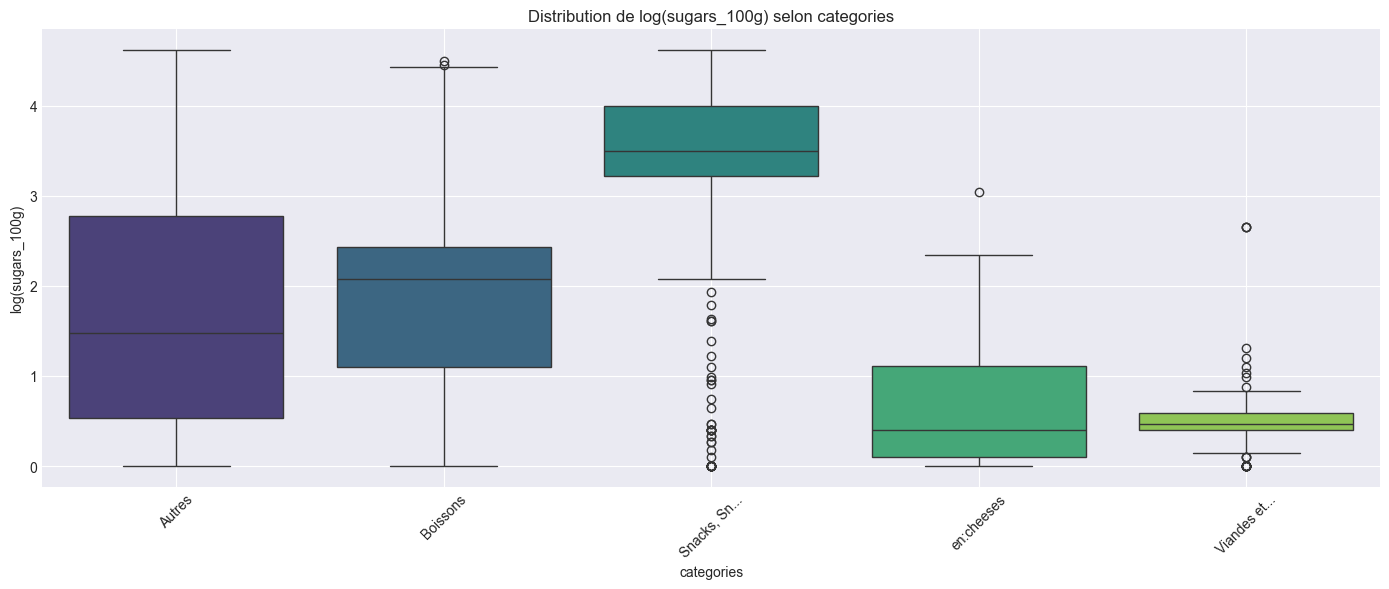

Statistique F : 326.104
P-valeur : 0.00000
🔴 Il existe une différence significative entre les groupes pour log(sugars_100g).

📊 ANOVA pour saturated-fat_100g


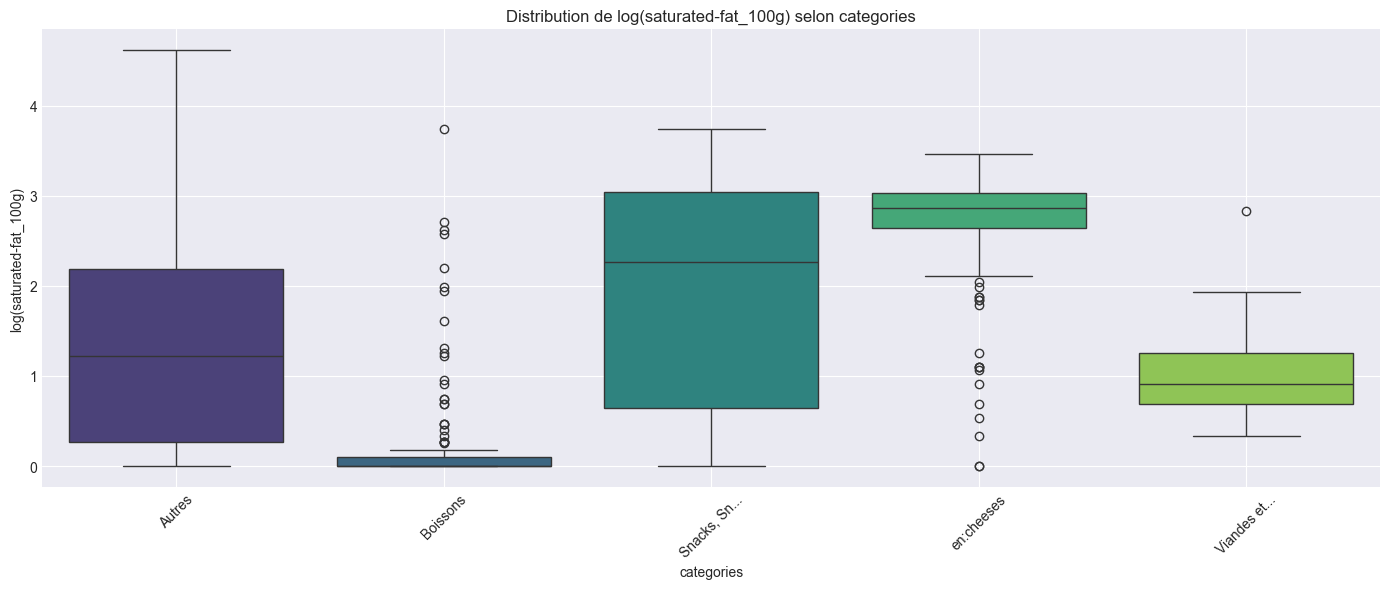

Statistique F : 235.109
P-valeur : 0.00000
🔴 Il existe une différence significative entre les groupes pour log(saturated-fat_100g).

📊 ANOVA pour salt_100g


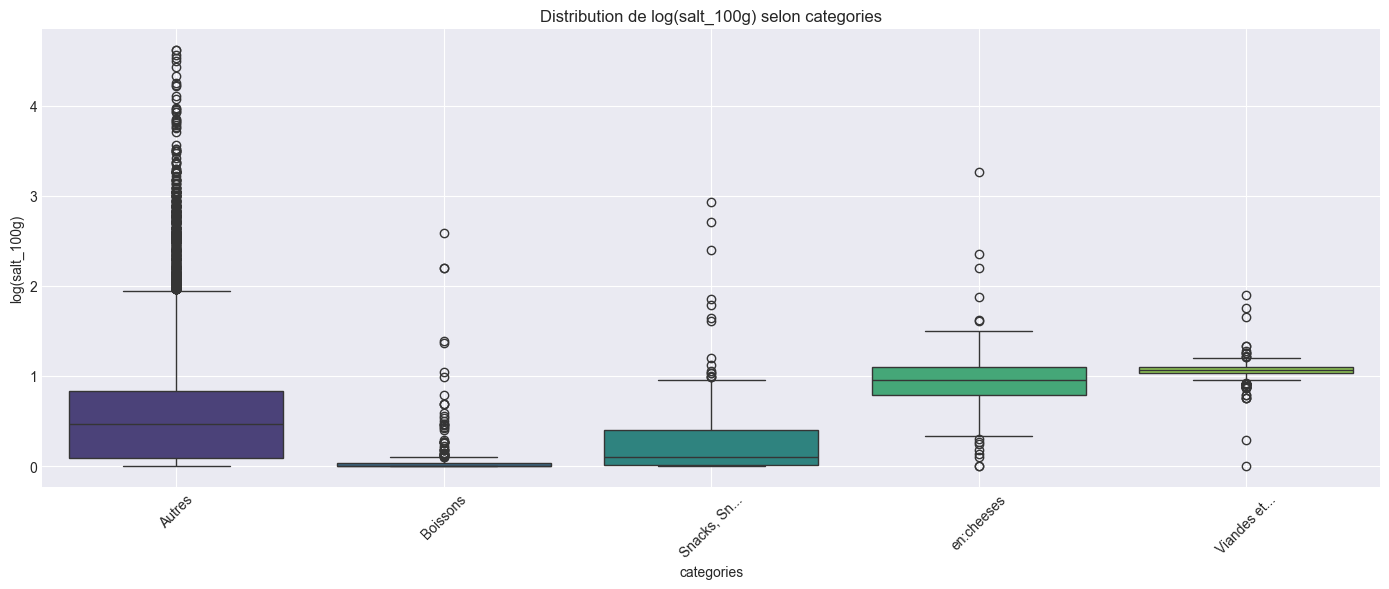

Statistique F : 200.848
P-valeur : 0.00000
🔴 Il existe une différence significative entre les groupes pour log(salt_100g).

📊 ANOVA pour fiber_100g


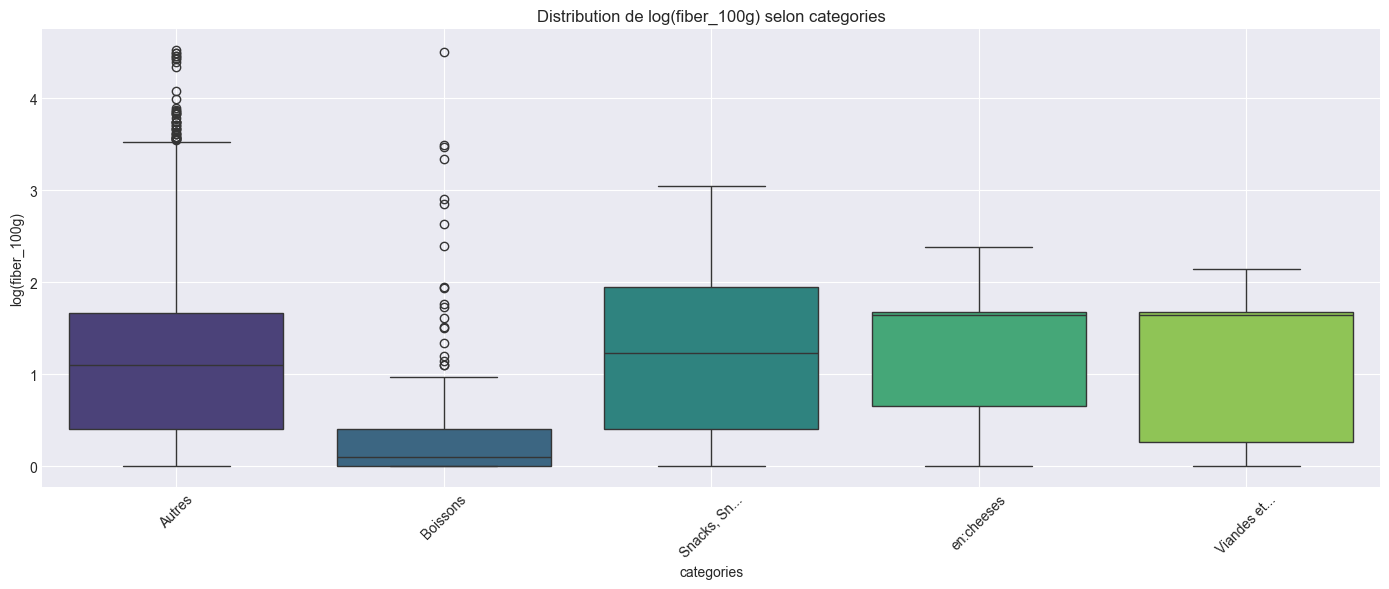

Statistique F : 91.966
P-valeur : 0.00000
🔴 Il existe une différence significative entre les groupes pour log(fiber_100g).


In [67]:
# Variables
categorie = "categories"
variables_numeriques = ["sugars_100g", "saturated-fat_100g", "salt_100g", "fiber_100g"]

df_cleaned_filtre[categorie] = df_cleaned_filtre[categorie].replace('unknown', 'Autres')

# 1. Regrouper les catégories peu fréquentes
top_categories = df_cleaned_filtre[categorie].value_counts().nlargest(6).index  # Top 5 catégories
df_cleaned_filtre[categorie + "_regroupe"] = df_cleaned_filtre[categorie].where(
    df_cleaned_filtre[categorie].isin(top_categories), "Autres"
)

# Tronquer les noms des catégories à 10 caractères
df_cleaned_filtre[categorie + "_regroupe"] = df_cleaned_filtre[categorie + "_regroupe"].apply(
    lambda x: x[:10] + '...' if len(x) > 10 else x
)

# 2. Appliquer une transformation logarithmique et réaliser l'ANOVA
for variable_numerique in variables_numeriques:
    print(f"\n📊 ANOVA pour {variable_numerique}")

    # Transformation logarithmique
    df_cleaned_filtre.loc[:, f"log_{variable_numerique}"] = np.log1p(df_cleaned_filtre[variable_numerique])

    # Boxplot avec regroupement des catégories
    plt.figure(figsize=(14, 6))  # Largeur augmentée à 14 pouces
    sns.boxplot(
        x=df_cleaned_filtre[categorie + "_regroupe"],
        y=df_cleaned_filtre[f"log_{variable_numerique}"],
        palette="viridis",
        hue=df_cleaned_filtre[categorie + "_regroupe"],
        legend=False
    )
    plt.title(f"Distribution de log({variable_numerique}) selon {categorie}")
    plt.xlabel(categorie)
    plt.ylabel(f"log({variable_numerique})")
    plt.xticks(rotation=45)  # Rotation des étiquettes de 45 degrés
    plt.grid(True)
    plt.tight_layout()  # Ajuster la mise en page pour éviter les chevauchements
    plt.show()

    # Réaliser l'ANOVA sur les groupes regroupés
    groupes = [
        df_cleaned_filtre[df_cleaned_filtre[categorie + "_regroupe"] == groupe][f"log_{variable_numerique}"]
        for groupe in df_cleaned_filtre[categorie + "_regroupe"].unique()
    ]
    stat, p_value = stats.f_oneway(*groupes)
    print(f"Statistique F : {stat:.3f}")
    print(f"P-valeur : {p_value:.5f}")

    if p_value < 0.05:
        print(f"🔴 Il existe une différence significative entre les groupes pour log({variable_numerique}).")
    else:
        print(f"🟢 Aucune différence significative détectée pour log({variable_numerique}).")

### Observations générales

- **Nutri-Score, Groupes PNNS et Catégories influencent fortement la teneur en nutriments** (p < 0.00000).
- **Les produits avec un Nutri-Score "e"** sont plus riches en sucres, graisses saturées et sel, et plus pauvres en fibres.
- **Les snacks sucrés et boissons** contiennent le plus de sucre, tandis que **les viandes et fromages** en contiennent très peu.
- **Les produits laitiers et snacks** sont les plus riches en graisses saturées, les boissons en contiennent très peu.
- **Le sel est plus présent dans les viandes, fromages et plats transformés**, alors que les boissons en sont quasiment dépourvues.
- **Les fibres se retrouvent principalement dans les céréales et snacks**, et sont peu présentes dans les boissons et produits animaux.
- Ces résultats confirment **la pertinence du Nutri-Score, des Groupes PNNS et des Catégories pour prédire les valeurs manquantes** et alimenter un **système de suggestion ou d’auto-complétion** des données nutritionnelles.

# 6 : Conclusion

Au terme de ce travail, plusieurs éléments clés émergent pour évaluer la faisabilité d’un système de suggestion ou d’auto-complétion des données dans Open Food Facts :

### **Nettoyage et structuration des données**
   - Nous avons identifié et isolé les variables pertinentes (informations générales, tags, composition nutritionnelle, etc.).
   - Des stratégies de traitement des valeurs manquantes ont été mises en place (imputation par 0, seuils métiers, KNN Imputer), ainsi que la détection et la suppression des valeurs aberrantes (IQR, règles métiers).
   - Le processus est **automatisable**, ce qui garantit une robustesse face à l’évolution de la base (ajout de nouveaux produits, par exemple).

### **Analyse exploratoire univariée et bivariée**
   - Les distributions de variables nutritionnelles (sucres, sel, graisses, etc.) confirment une **forte hétérogénéité** des produits dans la base.
   - Les corrélations statistiques (par ex. entre `carbohydrates_100g` et `sugars_100g`, ou entre `fat_100g` et `saturated-fat_100g`) soulignent des liens logiques entre familles de nutriments.
   - L’analyse bivariée (nuages de points, matrices de corrélation) révèle la concentration de produits dans certaines catégories, notamment les snacks sucrés, boissons, viandes/charcuteries, etc.

### **Approfondissement par analyses multivariées**
   - L’ACP (Analyse en Composantes Principales) montre que **trois axes** (sel, sucre, gras saturés) permettent déjà d’expliquer l’essentiel de la variabilité nutritionnelle.
   - Les tests d’ANOVA indiquent que les différentes catégories (Nutri-Score, PNNS, etc.) **expliquent significativement** certaines différences de teneurs en nutriments, ce qui légitime l’idée de recourir à ces informations pour suggérer ou autocompléter des valeurs manquantes.

### **Faisabilité du système de suggestion**
   - Les corrélations trouvées entre les variables (notamment celles liées aux catégories alimentaires et au Nutri-Score) suggèrent qu’un **algorithme de prédiction** ou de recommandation pourrait estimer efficacement certaines valeurs nutritionnelles manquantes.
   - Les méthodes déployées (KNN, scalers, imputation par 0) sont adaptables et montrent un **impact limité** sur la distribution globale des données, ce qui est un gage de fiabilité.

### **Respect des principes du RGPD**
   - Même si la base de données **ne contient pas de données personnelles**, il est essentiel de respecter les grands principes :
     1. **Licéité, loyauté et transparence** : les usagers sont informés de la finalité (améliorer la base) et du fonctionnement du système de suggestion.
     2. **Limitation des finalités** : les données ne sont utilisées que pour la qualité nutritionnelle et ne sont pas détournées à d’autres fins.
     3. **Minimisation des données** : seules les variables nécessaires à l’autocomplétion sont exploitées.
     4. **Exactitude** : le système de suggestion contribue à renseigner des informations plus fiables, notamment en identifiant et en corrigeant les valeurs aberrantes.
     5. **Sécurité et confidentialité** : les données sont stockées et manipulées dans un environnement protégé, sans compromettre la confidentialité des informations transmises.

---

### Synthèse
En conclusion, l’ensemble des étapes de nettoyage, d’exploration et d’analyses statistiques confirme qu’il est **tout à fait envisageable** de mettre en place une application d’autocomplétion pour faciliter la saisie des fiches produits dans Open Food Facts. Les corrélations trouvées et la significativité des variables (notamment via l’ANOVA) renforcent l’idée qu’un **modèle prédictif** pourra, avec une bonne fiabilité, proposer des valeurs pertinentes lorsque des informations font défaut. De plus, le projet s’inscrit dans un cadre **RGPD-compatible** : il ne manipule pas de données sensibles et respecte les principes fondamentaux de protection des informations traitées.